## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.015955927
RMSE of after m1 0.019903485
RMSE of after m3 0.07817939
RMSE of after m4 0.07870821
RMSE of after m0 0.014518581
RMSE of after m1 0.055837248
RMSE of after m3 0.1477848
RMSE of after m4 0.14640383
RMSE of after m0 0.022985889
RMSE of after m1 0.04009601
RMSE of after m3 0.089379124
RMSE of after m4 0.09203076
RMSE of after m0 0.023267046
RMSE of after m1 0.02467512
RMSE of after m3 0.090026364
RMSE of after m4 0.09087419
RMSE of after m0 0.020757074
RMSE of after m1 0.02009003
RMSE of after m3 0.01690196
RMSE of after m4 0.017224463
RMSE of after m0 0.019228224
RMSE of after m1 0.016826741
RMSE of after m3 0.011024926
RMSE of after m4 0.011710198
RMSE of after m0 0.018557398
RMSE of after m1 0.015764339
RMSE of after m3 0.009375972
RMSE of after m4 0.009957707
RMSE of after m0 0.018134614
RMSE of after m1 0.015549683
RMSE of after m3 0.010425117
RMSE of after m4 0.010811509
RMSE of after m0 0.01839736
RMSE of after m1 0.016086038
RMSE of after m3 0.0113804

RMSE of after m0 0.015118729
RMSE of after m1 0.023506418
RMSE of after m3 0.18972333
RMSE of after m4 0.18658829
RMSE of after m0 0.007792614
RMSE of after m1 0.008576836
RMSE of after m3 0.026381249
RMSE of after m4 0.0243727
RMSE of after m0 0.009526869
RMSE of after m1 0.010083725
RMSE of after m3 0.0421065
RMSE of after m4 0.046019692
RMSE of after m0 0.009393042
RMSE of after m1 0.011325409
RMSE of after m3 0.030858874
RMSE of after m4 0.029808799
RMSE of after m0 0.010285034
RMSE of after m1 0.013249002
RMSE of after m3 0.06625607
RMSE of after m4 0.065137625
RMSE of after m0 0.009125734
RMSE of after m1 0.0137356585
RMSE of after m3 0.033011626
RMSE of after m4 0.037946906
RMSE of after m0 0.008596247
RMSE of after m1 0.014596719
RMSE of after m3 0.036350157
RMSE of after m4 0.041545812
RMSE of after m0 0.0072846273
RMSE of after m1 0.012779305
RMSE of after m3 0.03178859
RMSE of after m4 0.03515794
RMSE of after m0 0.008523658
RMSE of after m1 0.012053964
RMSE of after m3 0.02

RMSE of after m1 0.0203582
RMSE of after m3 0.056777872
RMSE of after m4 0.067501836
RMSE of after m0 0.010631618
RMSE of after m1 0.01966602
RMSE of after m3 0.039865687
RMSE of after m4 0.05110483
RMSE of after m0 0.0087290825
RMSE of after m1 0.012664626
RMSE of after m3 0.059154622
RMSE of after m4 0.058914714
RMSE of after m0 0.008423593
RMSE of after m1 0.011023106
RMSE of after m3 0.032184675
RMSE of after m4 0.033398196
RMSE of after m0 0.008955818
RMSE of after m1 0.0125395
RMSE of after m3 0.032101102
RMSE of after m4 0.030934839
RMSE of after m0 0.009285526
RMSE of after m1 0.013135058
RMSE of after m3 0.0367191
RMSE of after m4 0.029565418
RMSE of after m0 0.008633956
RMSE of after m1 0.013235392
RMSE of after m3 0.045276586
RMSE of after m4 0.04342015
RMSE of after m0 0.008147257
RMSE of after m1 0.014740954
RMSE of after m3 0.039076567
RMSE of after m4 0.043398574
RMSE of after m0 0.008542743
RMSE of after m1 0.014813299
RMSE of after m3 0.035930037
RMSE of after m4 0.041

RMSE of after m1 0.01973575
RMSE of after m3 0.060843296
RMSE of after m4 0.073231846
RMSE of after m0 0.010710784
RMSE of after m1 0.018394949
RMSE of after m3 0.033981673
RMSE of after m4 0.042168103
RMSE of after m0 0.011086333
RMSE of after m1 0.018880406
RMSE of after m3 0.044725478
RMSE of after m4 0.051928136
RMSE of after m0 0.010200146
RMSE of after m1 0.017566849
RMSE of after m3 0.04154266
RMSE of after m4 0.051512685
RMSE of after m0 0.010232318
RMSE of after m1 0.016298868
RMSE of after m3 0.055421673
RMSE of after m4 0.054696646
RMSE of after m0 0.009686386
RMSE of after m1 0.016881678
RMSE of after m3 0.03343277
RMSE of after m4 0.033455856
RMSE of after m0 0.00901501
RMSE of after m1 0.016258543
RMSE of after m3 0.01885481
RMSE of after m4 0.026000394
RMSE of after m0 0.008773983
RMSE of after m1 0.015119097
RMSE of after m3 0.015271945
RMSE of after m4 0.025602622
RMSE of after m0 0.0101601975
RMSE of after m1 0.01642088
RMSE of after m3 0.018434076
RMSE of after m4 0.

RMSE of after m1 0.008814336
RMSE of after m3 0.021731783
RMSE of after m4 0.022703491
RMSE of after m0 0.008615068
RMSE of after m1 0.010362035
RMSE of after m3 0.051753167
RMSE of after m4 0.047657836
RMSE of after m0 0.008422314
RMSE of after m1 0.009612177
RMSE of after m3 0.034312014
RMSE of after m4 0.03527085
RMSE of after m0 0.0088394135
RMSE of after m1 0.009266054
RMSE of after m3 0.04095617
RMSE of after m4 0.04056246
RMSE of after m0 0.0091926865
RMSE of after m1 0.008224999
RMSE of after m3 0.034948006
RMSE of after m4 0.03377123
RMSE of after m0 0.008428034
RMSE of after m1 0.008425055
RMSE of after m3 0.021780483
RMSE of after m4 0.017754
RMSE of after m0 0.007819889
RMSE of after m1 0.008120973
RMSE of after m3 0.029520804
RMSE of after m4 0.023927484
RMSE of after m0 0.008506807
RMSE of after m1 0.009136465
RMSE of after m3 0.047740392
RMSE of after m4 0.041733716
RMSE of after m0 0.008126006
RMSE of after m1 0.008854446
RMSE of after m3 0.020805988
RMSE of after m4 0.

RMSE of after m3 0.01695029
RMSE of after m4 0.016410496
RMSE of after m0 0.018571682
RMSE of after m1 0.016496487
RMSE of after m3 0.017737247
RMSE of after m4 0.016967367
RMSE of after m0 0.018265009
RMSE of after m1 0.020171503
RMSE of after m3 0.019055167
RMSE of after m4 0.01783092
RMSE of after m0 0.017069463
RMSE of after m1 0.019397322
RMSE of after m3 0.019547526
RMSE of after m4 0.018386342
RMSE of after m0 0.017200317
RMSE of after m1 0.020679187
RMSE of after m3 0.0194497
RMSE of after m4 0.018374916
RMSE of after m0 0.017074713
RMSE of after m1 0.016137276
RMSE of after m3 0.061130244
RMSE of after m4 0.06106466
RMSE of after m0 0.021147152
RMSE of after m1 0.019861674
RMSE of after m3 0.048200034
RMSE of after m4 0.047488272
RMSE of after m0 0.020773225
RMSE of after m1 0.018740524
RMSE of after m3 0.027777959
RMSE of after m4 0.027038565
RMSE of after m0 0.019774802
RMSE of after m1 0.021693634
RMSE of after m3 0.02892891
RMSE of after m4 0.028449787
RMSE of after m0 0.0

RMSE of after m3 0.016408224
RMSE of after m4 0.01513744
RMSE of after m0 0.026739247
RMSE of after m1 0.022056947
RMSE of after m3 0.016597433
RMSE of after m4 0.014818126
RMSE of after m0 0.027187314
RMSE of after m1 0.021987714
RMSE of after m3 0.017001785
RMSE of after m4 0.015500275
RMSE of after m0 0.026477067
RMSE of after m1 0.023058886
RMSE of after m3 0.024110777
RMSE of after m4 0.0231832
RMSE of after m0 0.025144165
RMSE of after m1 0.021574775
RMSE of after m3 0.021991234
RMSE of after m4 0.021729983
RMSE of after m0 0.029514996
RMSE of after m1 0.021045001
RMSE of after m3 0.020343667
RMSE of after m4 0.020102866
RMSE of after m0 0.030663146
RMSE of after m1 0.022095192
RMSE of after m3 0.019905252
RMSE of after m4 0.01829357
RMSE of after m0 0.028640296
RMSE of after m1 0.023528833
RMSE of after m3 0.019647779
RMSE of after m4 0.017591069
RMSE of after m0 0.026551243
RMSE of after m1 0.023113953
RMSE of after m3 0.025152132
RMSE of after m4 0.024206048
RMSE of after m0 0

RMSE of after m1 0.024845298
RMSE of after m3 0.019396387
RMSE of after m4 0.022479484
RMSE of after m0 0.01942692
RMSE of after m1 0.024281465
RMSE of after m3 0.013312489
RMSE of after m4 0.014838538
RMSE of after m0 0.016719077
RMSE of after m1 0.026616791
RMSE of after m3 0.017604299
RMSE of after m4 0.019794323
RMSE of after m0 0.016275195
RMSE of after m1 0.026255067
RMSE of after m3 0.0476289
RMSE of after m4 0.048855577
RMSE of after m0 0.017542623
RMSE of after m1 0.025809389
RMSE of after m3 0.036046185
RMSE of after m4 0.03746146
RMSE of after m0 0.022661261
RMSE of after m1 0.025532147
RMSE of after m3 0.2691232
RMSE of after m4 0.26715788
RMSE of after m0 0.0102113765
RMSE of after m1 0.0120011475
RMSE of after m3 0.054603092
RMSE of after m4 0.05838793
RMSE of after m0 0.009511014
RMSE of after m1 0.0110881
RMSE of after m3 0.02830617
RMSE of after m4 0.03635092
RMSE of after m0 0.008098359
RMSE of after m1 0.007222097
RMSE of after m3 0.03872861
RMSE of after m4 0.037726

RMSE of after m1 0.014112348
RMSE of after m3 0.027358012
RMSE of after m4 0.02940312
RMSE of after m0 0.00954999
RMSE of after m1 0.014972836
RMSE of after m3 0.027694661
RMSE of after m4 0.032279935
RMSE of after m0 0.009899199
RMSE of after m1 0.015193355
RMSE of after m3 0.029857928
RMSE of after m4 0.028957447
RMSE of after m0 0.009271784
RMSE of after m1 0.015847526
RMSE of after m3 0.029337684
RMSE of after m4 0.03592926
RMSE of after m0 0.007895335
RMSE of after m1 0.015502597
RMSE of after m3 0.01778939
RMSE of after m4 0.023253206
RMSE of after m0 0.008718764
RMSE of after m1 0.013475934
RMSE of after m3 0.01552075
RMSE of after m4 0.022237215
RMSE of after m0 0.009209134
RMSE of after m1 0.015218137
RMSE of after m3 0.023077901
RMSE of after m4 0.030291015
RMSE of after m0 0.010445049
RMSE of after m1 0.016766142
RMSE of after m3 0.027580384
RMSE of after m4 0.035748813
RMSE of after m0 0.011175525
RMSE of after m1 0.0183395
RMSE of after m3 0.02500103
RMSE of after m4 0.037

RMSE of after m1 0.016728902
RMSE of after m3 0.036162917
RMSE of after m4 0.043624204
RMSE of after m0 0.010722526
RMSE of after m1 0.018778075
RMSE of after m3 0.023696685
RMSE of after m4 0.03879559
RMSE of after m0 0.0121707525
RMSE of after m1 0.02041568
RMSE of after m3 0.053207356
RMSE of after m4 0.0653815
RMSE of after m0 0.01149443
RMSE of after m1 0.020353252
RMSE of after m3 0.020501146
RMSE of after m4 0.03781632
RMSE of after m0 0.013497827
RMSE of after m1 0.02352546
RMSE of after m3 0.032959975
RMSE of after m4 0.050155137
RMSE of after m0 0.009999872
RMSE of after m1 0.020598628
RMSE of after m3 0.021143666
RMSE of after m4 0.033715297
RMSE of after m0 0.008178362
RMSE of after m1 0.017750358
RMSE of after m3 0.018237468
RMSE of after m4 0.030115694
RMSE of after m0 0.009436904
RMSE of after m1 0.015698677
RMSE of after m3 0.08419114
RMSE of after m4 0.080612674
RMSE of after m0 0.009828801
RMSE of after m1 0.013874234
RMSE of after m3 0.0576197
RMSE of after m4 0.0418

RMSE of after m4 0.06819854
RMSE of after m0 0.01569949
RMSE of after m1 0.03732325
RMSE of after m3 0.08284623
RMSE of after m4 0.08289055
RMSE of after m0 0.0176643
RMSE of after m1 0.017524026
RMSE of after m3 0.02668543
RMSE of after m4 0.026561012
RMSE of after m0 0.017011503
RMSE of after m1 0.018092116
RMSE of after m3 0.027427483
RMSE of after m4 0.027253533
RMSE of after m0 0.015494188
RMSE of after m1 0.01601196
RMSE of after m3 0.023108987
RMSE of after m4 0.022603868
RMSE of after m0 0.015178145
RMSE of after m1 0.016401082
RMSE of after m3 0.014568514
RMSE of after m4 0.013773967
RMSE of after m0 0.018298939
RMSE of after m1 0.02141225
RMSE of after m3 0.019568145
RMSE of after m4 0.018819768
RMSE of after m0 0.021736002
RMSE of after m1 0.024608785
RMSE of after m3 0.021072889
RMSE of after m4 0.020156598
RMSE of after m0 0.02181372
RMSE of after m1 0.023200514
RMSE of after m3 0.02208869
RMSE of after m4 0.021337314
RMSE of after m0 0.020972274
RMSE of after m1 0.0220609

RMSE of after m3 0.021442376
RMSE of after m4 0.02010885
RMSE of after m0 0.028384946
RMSE of after m1 0.020968078
RMSE of after m3 0.022761595
RMSE of after m4 0.021367537
RMSE of after m0 0.02833837
RMSE of after m1 0.023459174
RMSE of after m3 0.021458244
RMSE of after m4 0.019385664
RMSE of after m0 0.027130343
RMSE of after m1 0.02161781
RMSE of after m3 0.016362282
RMSE of after m4 0.013080368
RMSE of after m0 0.030512135
RMSE of after m1 0.024006676
RMSE of after m3 0.017216232
RMSE of after m4 0.014052796
RMSE of after m0 0.031272057
RMSE of after m1 0.025345387
RMSE of after m3 0.019425813
RMSE of after m4 0.016302258
RMSE of after m0 0.029179547
RMSE of after m1 0.023352597
RMSE of after m3 0.017832566
RMSE of after m4 0.014614001
RMSE of after m0 0.028034111
RMSE of after m1 0.023074541
RMSE of after m3 0.025402062
RMSE of after m4 0.023183826
RMSE of after m0 0.029127514
RMSE of after m1 0.022328034
RMSE of after m3 0.018992556
RMSE of after m4 0.01699568
RMSE of after m0 0

RMSE of after m1 0.026983999
RMSE of after m3 0.021705866
RMSE of after m4 0.020981772
RMSE of after m0 0.020137418
RMSE of after m1 0.024806777
RMSE of after m3 0.027011475
RMSE of after m4 0.027128285
RMSE of after m0 0.02171057
RMSE of after m1 0.025340099
RMSE of after m3 0.021357244
RMSE of after m4 0.020654395
RMSE of after m0 0.02058509
RMSE of after m1 0.025460815
RMSE of after m3 0.024666006
RMSE of after m4 0.024094429
RMSE of after m0 0.020878877
RMSE of after m1 0.024434524
RMSE of after m3 0.01901276
RMSE of after m4 0.018505562
RMSE of after m0 0.021109136
RMSE of after m1 0.023499515
RMSE of after m3 0.02133083
RMSE of after m4 0.02121358
RMSE of after m0 0.022176262
RMSE of after m1 0.022806175
RMSE of after m3 0.0262313
RMSE of after m4 0.025227081
RMSE of after m0 0.025339542
RMSE of after m1 0.02489268
RMSE of after m3 0.020849802
RMSE of after m4 0.02073327
RMSE of after m0 0.024257509
RMSE of after m1 0.024358068
RMSE of after m3 0.01714349
RMSE of after m4 0.01737

RMSE of after m1 0.012856175
RMSE of after m3 0.03452915
RMSE of after m4 0.03300418
RMSE of after m0 0.009252721
RMSE of after m1 0.009663219
RMSE of after m3 0.04373819
RMSE of after m4 0.04185574
RMSE of after m0 0.008725664
RMSE of after m1 0.011979505
RMSE of after m3 0.01859713
RMSE of after m4 0.020257017
RMSE of after m0 0.0088470625
RMSE of after m1 0.012756656
RMSE of after m3 0.037531506
RMSE of after m4 0.03733481
RMSE of after m0 0.012639293
RMSE of after m1 0.018338902
RMSE of after m3 0.043606043
RMSE of after m4 0.052056693
RMSE of after m0 0.009560983
RMSE of after m1 0.016867286
RMSE of after m3 0.0125214
RMSE of after m4 0.01894176
RMSE of after m0 0.010069848
RMSE of after m1 0.018214898
RMSE of after m3 0.027903488
RMSE of after m4 0.041267805
RMSE of after m0 0.008990706
RMSE of after m1 0.016525552
RMSE of after m3 0.018263137
RMSE of after m4 0.028603578
RMSE of after m0 0.009963966
RMSE of after m1 0.015233397
RMSE of after m3 0.041298606
RMSE of after m4 0.039

RMSE of after m0 0.012006783
RMSE of after m1 0.020540707
RMSE of after m3 0.022981737
RMSE of after m4 0.028590683
RMSE of after m0 0.010477304
RMSE of after m1 0.019628968
RMSE of after m3 0.013438412
RMSE of after m4 0.027239658
RMSE of after m0 0.011839538
RMSE of after m1 0.021016322
RMSE of after m3 0.015199756
RMSE of after m4 0.027781295
RMSE of after m0 0.012103662
RMSE of after m1 0.021633206
RMSE of after m3 0.01672814
RMSE of after m4 0.027052617
RMSE of after m0 0.012531288
RMSE of after m1 0.022627834
RMSE of after m3 0.021972127
RMSE of after m4 0.03078381
RMSE of after m0 0.012242397
RMSE of after m1 0.023300974
RMSE of after m3 0.022801146
RMSE of after m4 0.031333715
RMSE of after m0 0.008765867
RMSE of after m1 0.018996824
RMSE of after m3 0.032294475
RMSE of after m4 0.034405764
RMSE of after m0 0.009773105
RMSE of after m1 0.016417198
RMSE of after m3 0.032502167
RMSE of after m4 0.036467
RMSE of after m0 0.010929835
RMSE of after m1 0.017766224
RMSE of after m3 0.

RMSE of after m1 0.007921081
RMSE of after m3 0.048805665
RMSE of after m4 0.043333694
RMSE of after m0 0.007763241
RMSE of after m1 0.00652832
RMSE of after m3 0.030975848
RMSE of after m4 0.027700812
RMSE of after m0 0.009116339
RMSE of after m1 0.0066336854
RMSE of after m3 0.03042692
RMSE of after m4 0.025629407
RMSE of after m0 0.008619548
RMSE of after m1 0.007228945
RMSE of after m3 0.035865285
RMSE of after m4 0.028801885
RMSE of after m0 0.0064707543
RMSE of after m1 0.006690014
RMSE of after m3 0.041300848
RMSE of after m4 0.035921693
RMSE of after m0 0.006021027
RMSE of after m1 0.008373492
RMSE of after m3 0.023928035
RMSE of after m4 0.025571352
RMSE of after m0 0.0059226532
RMSE of after m1 0.0069429073
RMSE of after m3 0.048114423
RMSE of after m4 0.058026463
RMSE of after m0 0.0077735167
RMSE of after m1 0.006294758
RMSE of after m3 0.03139844
RMSE of after m4 0.028353047
RMSE of after m0 0.0067130383
RMSE of after m1 0.0074504553
RMSE of after m3 0.0722463
RMSE of afte

RMSE of after m1 0.02116668
RMSE of after m3 0.017615104
RMSE of after m4 0.01602031
RMSE of after m0 0.02615426
RMSE of after m1 0.021694157
RMSE of after m3 0.018544512
RMSE of after m4 0.016915629
RMSE of after m0 0.022671977
RMSE of after m1 0.017808346
RMSE of after m3 0.0091434475
RMSE of after m4 0.008613418
RMSE of after m0 0.021857541
RMSE of after m1 0.01870015
RMSE of after m3 0.01947365
RMSE of after m4 0.018547628
RMSE of after m0 0.021313077
RMSE of after m1 0.017270563
RMSE of after m3 0.015837604
RMSE of after m4 0.01340476
RMSE of after m0 0.02322094
RMSE of after m1 0.018211437
RMSE of after m3 0.018600337
RMSE of after m4 0.017266497
RMSE of after m0 0.031128893
RMSE of after m1 0.01908822
RMSE of after m3 0.015676126
RMSE of after m4 0.01463781
RMSE of after m0 0.02599125
RMSE of after m1 0.01944554
RMSE of after m3 0.01250051
RMSE of after m4 0.011272037
RMSE of after m0 0.027647745
RMSE of after m1 0.020168068
RMSE of after m3 0.015703533
RMSE of after m4 0.014834

RMSE of after m3 0.019688638
RMSE of after m4 0.018060565
RMSE of after m0 0.021050613
RMSE of after m1 0.02330429
RMSE of after m3 0.016650874
RMSE of after m4 0.014380237
RMSE of after m0 0.021463677
RMSE of after m1 0.023585368
RMSE of after m3 0.016801132
RMSE of after m4 0.01458966
RMSE of after m0 0.021647396
RMSE of after m1 0.022761902
RMSE of after m3 0.01691307
RMSE of after m4 0.01500962
RMSE of after m0 0.02021879
RMSE of after m1 0.019269
RMSE of after m3 0.018094186
RMSE of after m4 0.016049303
RMSE of after m0 0.018228056
RMSE of after m1 0.020622276
RMSE of after m3 0.030612903
RMSE of after m4 0.027316874
RMSE of after m0 0.022591727
RMSE of after m1 0.025629772
RMSE of after m3 0.021259049
RMSE of after m4 0.019444516
RMSE of after m0 0.022148483
RMSE of after m1 0.026155332
RMSE of after m3 0.023886984
RMSE of after m4 0.021409879
RMSE of after m0 0.022055257
RMSE of after m1 0.024168797
RMSE of after m3 0.038802847
RMSE of after m4 0.038125087
RMSE of after m0 0.020

RMSE of after m3 0.036248796
RMSE of after m4 0.035183053
RMSE of after m0 0.006551524
RMSE of after m1 0.009256384
RMSE of after m3 0.015948415
RMSE of after m4 0.013313593
RMSE of after m0 0.008306904
RMSE of after m1 0.008890015
RMSE of after m3 0.026580987
RMSE of after m4 0.021290544
RMSE of after m0 0.007770242
RMSE of after m1 0.009841336
RMSE of after m3 0.019128224
RMSE of after m4 0.021832447
RMSE of after m0 0.008593072
RMSE of after m1 0.012794812
RMSE of after m3 0.048767567
RMSE of after m4 0.056992315
RMSE of after m0 0.009424109
RMSE of after m1 0.014682277
RMSE of after m3 0.03298979
RMSE of after m4 0.039582327
RMSE of after m0 0.009436141
RMSE of after m1 0.015654901
RMSE of after m3 0.029608909
RMSE of after m4 0.03327513
RMSE of after m0 0.007674865
RMSE of after m1 0.014025356
RMSE of after m3 0.014878311
RMSE of after m4 0.019518072
RMSE of after m0 0.0080539845
RMSE of after m1 0.012134232
RMSE of after m3 0.019643042
RMSE of after m4 0.022773199
RMSE of after m

RMSE of after m1 0.020094888
RMSE of after m3 0.035742186
RMSE of after m4 0.046727523
RMSE of after m0 0.010511792
RMSE of after m1 0.0200278
RMSE of after m3 0.016274147
RMSE of after m4 0.025792114
RMSE of after m0 0.009746518
RMSE of after m1 0.02060962
RMSE of after m3 0.01864016
RMSE of after m4 0.024007568
RMSE of after m0 0.00861618
RMSE of after m1 0.016871164
RMSE of after m3 0.0235235
RMSE of after m4 0.030366624
RMSE of after m0 0.0101267295
RMSE of after m1 0.018643107
RMSE of after m3 0.024522373
RMSE of after m4 0.036146827
RMSE of after m0 0.011682113
RMSE of after m1 0.020407915
RMSE of after m3 0.039078705
RMSE of after m4 0.04804243
RMSE of after m0 0.010046459
RMSE of after m1 0.01429854
RMSE of after m3 0.06485185
RMSE of after m4 0.05703981
RMSE of after m0 0.009188552
RMSE of after m1 0.016417041
RMSE of after m3 0.026452977
RMSE of after m4 0.027431006
RMSE of after m0 0.007889124
RMSE of after m1 0.015605476
RMSE of after m3 0.061798934
RMSE of after m4 0.05556

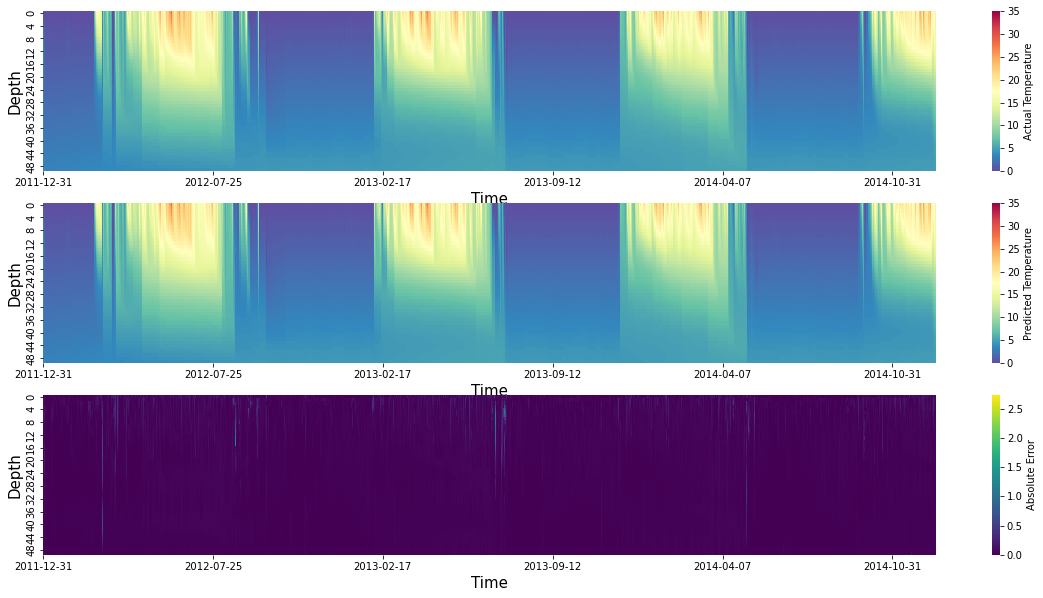

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

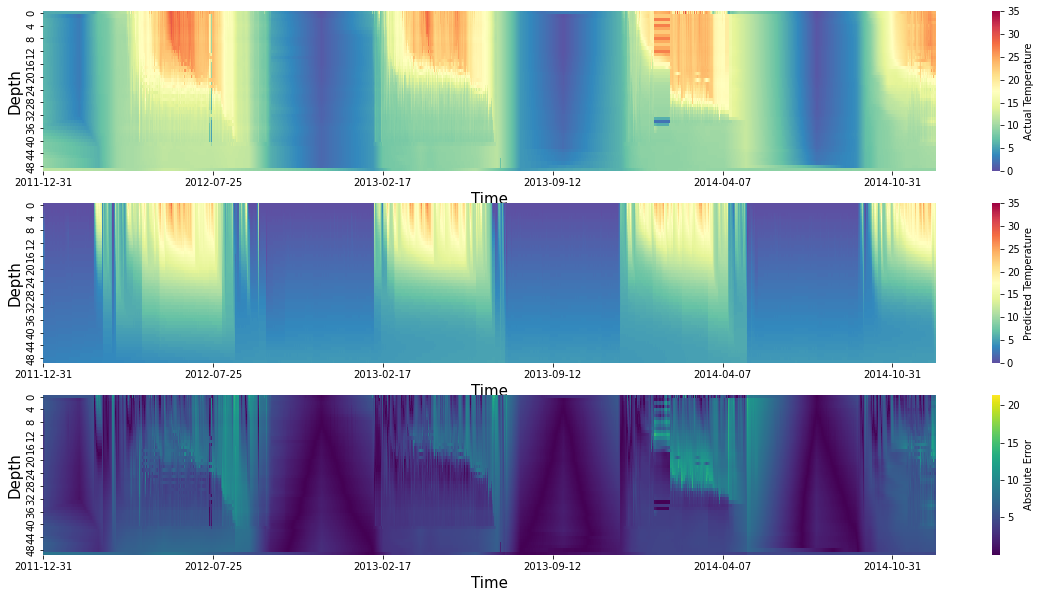

In [24]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [25]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0090550585
RMSE of after m1 0.016522184
RMSE of after m3 0.019098237
RMSE of after m4 0.02671519
RMSE of after m0 0.010058648
RMSE of after m1 0.016627615
RMSE of after m3 0.028392063
RMSE of after m4 0.03786254
RMSE of after m0 0.011175206
RMSE of after m1 0.018848468
RMSE of after m3 0.016677001
RMSE of after m4 0.028951336
RMSE of after m0 0.011941654
RMSE of after m1 0.019957943
RMSE of after m3 0.012618293
RMSE of after m4 0.020773193
RMSE of after m0 0.011727795
RMSE of after m1 0.02048253
RMSE of after m3 0.013001552
RMSE of after m4 0.021076027
RMSE of after m0 0.010224279
RMSE of after m1 0.019635735
RMSE of after m3 0.02228669
RMSE of after m4 0.025835821
RMSE of after m0 0.008626026
RMSE of after m1 0.01620574
RMSE of after m3 0.03327698
RMSE of after m4 0.031969585
RMSE of after m0 0.009490272
RMSE of after m1 0.015358796
RMSE of after m3 0.023268912
RMSE of after m4 0.027222903
RMSE of after m0 0.010674276
RMSE of after m1 0.017634274
RMSE of after m3 0.

RMSE of after m0 0.00701507
RMSE of after m1 0.010015175
RMSE of after m3 0.046667907
RMSE of after m4 0.048015352
RMSE of after m0 0.00987505
RMSE of after m1 0.012686832
RMSE of after m3 0.10598259
RMSE of after m4 0.09672293
RMSE of after m0 0.008555338
RMSE of after m1 0.013778052
RMSE of after m3 0.05177918
RMSE of after m4 0.061640345
RMSE of after m0 0.008458383
RMSE of after m1 0.012656327
RMSE of after m3 0.068850964
RMSE of after m4 0.07340243
RMSE of after m0 0.0073385816
RMSE of after m1 0.00959897
RMSE of after m3 0.050607327
RMSE of after m4 0.044568144
RMSE of after m0 0.0064122505
RMSE of after m1 0.009641298
RMSE of after m3 0.041827194
RMSE of after m4 0.03691131
RMSE of after m0 0.0066470597
RMSE of after m1 0.009231579
RMSE of after m3 0.07287598
RMSE of after m4 0.07176267
RMSE of after m0 0.007778761
RMSE of after m1 0.0056183287
RMSE of after m3 0.07103386
RMSE of after m4 0.045096178
RMSE of after m0 0.0108512975
RMSE of after m1 0.011498152
RMSE of after m3 0.2

RMSE of after m1 0.017933648
RMSE of after m3 0.03410931
RMSE of after m4 0.033002876
RMSE of after m0 0.015168714
RMSE of after m1 0.018412666
RMSE of after m3 0.01812183
RMSE of after m4 0.018296802
RMSE of after m0 0.015327407
RMSE of after m1 0.02091872
RMSE of after m3 0.034208473
RMSE of after m4 0.033898573
RMSE of after m0 0.01415858
RMSE of after m1 0.015806895
RMSE of after m3 0.05068364
RMSE of after m4 0.049368124
RMSE of after m0 0.016523397
RMSE of after m1 0.014103757
RMSE of after m3 0.048098043
RMSE of after m4 0.0476903
RMSE of after m0 0.017184312
RMSE of after m1 0.016877146
RMSE of after m3 0.015500584
RMSE of after m4 0.0151804
RMSE of after m0 0.017148841
RMSE of after m1 0.018557394
RMSE of after m3 0.029311895
RMSE of after m4 0.028998638
RMSE of after m0 0.016075712
RMSE of after m1 0.0139965415
RMSE of after m3 0.028380571
RMSE of after m4 0.027951067
RMSE of after m0 0.017038234
RMSE of after m1 0.016146246
RMSE of after m3 0.030720176
RMSE of after m4 0.030

RMSE of after m3 0.08148679
RMSE of after m4 0.07518771
RMSE of after m0 0.017370176
RMSE of after m1 0.0236657
RMSE of after m3 0.10145734
RMSE of after m4 0.09348822
RMSE of after m0 0.019359026
RMSE of after m1 0.02599844
RMSE of after m3 0.03388476
RMSE of after m4 0.030616997
RMSE of after m0 0.020198565
RMSE of after m1 0.026951628
RMSE of after m3 0.030749565
RMSE of after m4 0.027568752
RMSE of after m0 0.020453323
RMSE of after m1 0.027571296
RMSE of after m3 0.036115628
RMSE of after m4 0.032654695
RMSE of after m0 0.019821456
RMSE of after m1 0.0302185
RMSE of after m3 0.037250154
RMSE of after m4 0.033901893
RMSE of after m0 0.019916132
RMSE of after m1 0.029623514
RMSE of after m3 0.06355523
RMSE of after m4 0.062778346
RMSE of after m0 0.020188374
RMSE of after m1 0.026381321
RMSE of after m3 0.12353861
RMSE of after m4 0.12338992
RMSE of after m0 0.021996653
RMSE of after m1 0.027010528
RMSE of after m3 0.0967874
RMSE of after m4 0.09600069
RMSE of after m0 0.021282943
R

RMSE of after m1 0.009371482
RMSE of after m3 0.051244248
RMSE of after m4 0.044295173
RMSE of after m0 0.008335158
RMSE of after m1 0.010215317
RMSE of after m3 0.04683894
RMSE of after m4 0.03811513
RMSE of after m0 0.006883945
RMSE of after m1 0.009278928
RMSE of after m3 0.0109176785
RMSE of after m4 0.013013245
RMSE of after m0 0.0083124675
RMSE of after m1 0.008740981
RMSE of after m3 0.045617837
RMSE of after m4 0.038333356
RMSE of after m0 0.010002536
RMSE of after m1 0.00951149
RMSE of after m3 0.02575295
RMSE of after m4 0.024654748
RMSE of after m0 0.009463639
RMSE of after m1 0.009538235
RMSE of after m3 0.04125453
RMSE of after m4 0.03640684
RMSE of after m0 0.009088805
RMSE of after m1 0.010608837
RMSE of after m3 0.057533436
RMSE of after m4 0.05478502
RMSE of after m0 0.009613043
RMSE of after m1 0.012508695
RMSE of after m3 0.03594524
RMSE of after m4 0.036582526
RMSE of after m0 0.0070822802
RMSE of after m1 0.00836789
RMSE of after m3 0.06342449
RMSE of after m4 0.05

RMSE of after m1 0.014148939
RMSE of after m3 0.023205938
RMSE of after m4 0.029880667
RMSE of after m0 0.010054149
RMSE of after m1 0.016864546
RMSE of after m3 0.019890852
RMSE of after m4 0.032135602
RMSE of after m0 0.010035212
RMSE of after m1 0.015559104
RMSE of after m3 0.025204744
RMSE of after m4 0.031078141
RMSE of after m0 0.009400991
RMSE of after m1 0.016716305
RMSE of after m3 0.016789826
RMSE of after m4 0.02694911
RMSE of after m0 0.012549094
RMSE of after m1 0.020786064
RMSE of after m3 0.038370572
RMSE of after m4 0.04565992
RMSE of after m0 0.0071649873
RMSE of after m1 0.013358704
RMSE of after m3 0.030551473
RMSE of after m4 0.034477886
RMSE of after m0 0.00854526
RMSE of after m1 0.01327171
RMSE of after m3 0.039458487
RMSE of after m4 0.03719982
RMSE of after m0 0.009075928
RMSE of after m1 0.014131409
RMSE of after m3 0.019610303
RMSE of after m4 0.026988996
RMSE of after m0 0.008820393
RMSE of after m1 0.013943333
RMSE of after m3 0.027775507
RMSE of after m4 0

RMSE of after m0 0.010001555
RMSE of after m1 0.015385875
RMSE of after m3 0.044282064
RMSE of after m4 0.044171676
RMSE of after m0 0.010845656
RMSE of after m1 0.017901212
RMSE of after m3 0.04494737
RMSE of after m4 0.05168158
RMSE of after m0 0.012466554
RMSE of after m1 0.021123234
RMSE of after m3 0.07269841
RMSE of after m4 0.08276011
RMSE of after m0 0.0123182945
RMSE of after m1 0.0224183
RMSE of after m3 0.026142703
RMSE of after m4 0.04021856
RMSE of after m0 0.008413073
RMSE of after m1 0.016880069
RMSE of after m3 0.016923621
RMSE of after m4 0.023854205
RMSE of after m0 0.0097714225
RMSE of after m1 0.016699605
RMSE of after m3 0.023981227
RMSE of after m4 0.028637076
RMSE of after m0 0.010889236
RMSE of after m1 0.01825191
RMSE of after m3 0.028276647
RMSE of after m4 0.03226021
RMSE of after m0 0.01116537
RMSE of after m1 0.020111546
RMSE of after m3 0.015383753
RMSE of after m4 0.030392883
RMSE of after m0 0.0119486535
RMSE of after m1 0.021668786
RMSE of after m3 0.01

RMSE of after m1 0.006935313
RMSE of after m3 0.041031953
RMSE of after m4 0.03359187
RMSE of after m0 0.00662818
RMSE of after m1 0.007690817
RMSE of after m3 0.1067043
RMSE of after m4 0.09736273
RMSE of after m0 0.0067888424
RMSE of after m1 0.00459844
RMSE of after m3 0.036716986
RMSE of after m4 0.02995281
RMSE of after m0 0.009777592
RMSE of after m1 0.007939709
RMSE of after m3 0.04609556
RMSE of after m4 0.03997994
RMSE of after m0 0.011131741
RMSE of after m1 0.012932649
RMSE of after m3 0.1737849
RMSE of after m4 0.16515914
RMSE of after m0 0.010972443
RMSE of after m1 0.012642712
RMSE of after m3 0.07754236
RMSE of after m4 0.07544407
RMSE of after m0 0.010294792
RMSE of after m1 0.012126394
RMSE of after m3 0.038529053
RMSE of after m4 0.03599063
RMSE of after m0 0.00953863
RMSE of after m1 0.011659593
RMSE of after m3 0.037094284
RMSE of after m4 0.034533717
RMSE of after m0 0.009118008
RMSE of after m1 0.011087352
RMSE of after m3 0.038350668
RMSE of after m4 0.03618479
R

RMSE of after m1 0.016089717
RMSE of after m3 0.01366987
RMSE of after m4 0.0114426175
RMSE of after m0 0.023255311
RMSE of after m1 0.018338462
RMSE of after m3 0.018359896
RMSE of after m4 0.016027102
RMSE of after m0 0.023023862
RMSE of after m1 0.018994804
RMSE of after m3 0.020927753
RMSE of after m4 0.018302433
RMSE of after m0 0.021758737
RMSE of after m1 0.020131541
RMSE of after m3 0.022871664
RMSE of after m4 0.020616833
RMSE of after m0 0.020724276
RMSE of after m1 0.022484845
RMSE of after m3 0.022541843
RMSE of after m4 0.020533381
RMSE of after m0 0.022152018
RMSE of after m1 0.024072763
RMSE of after m3 0.018702103
RMSE of after m4 0.016519658
RMSE of after m0 0.021747153
RMSE of after m1 0.024342813
RMSE of after m3 0.018905992
RMSE of after m4 0.01646667
RMSE of after m0 0.020412374
RMSE of after m1 0.025558328
RMSE of after m3 0.020607647
RMSE of after m4 0.017435098
RMSE of after m0 0.019778788
RMSE of after m1 0.023885854
RMSE of after m3 0.023528563
RMSE of after m

RMSE of after m0 0.009437464
RMSE of after m1 0.008104501
RMSE of after m3 0.039951127
RMSE of after m4 0.039765667
RMSE of after m0 0.008577608
RMSE of after m1 0.007010205
RMSE of after m3 0.045965623
RMSE of after m4 0.04022127
RMSE of after m0 0.008481176
RMSE of after m1 0.007136303
RMSE of after m3 0.018582711
RMSE of after m4 0.020582253
RMSE of after m0 0.008067063
RMSE of after m1 0.006384515
RMSE of after m3 0.04274371
RMSE of after m4 0.041884214
RMSE of after m0 0.010059019
RMSE of after m1 0.008106481
RMSE of after m3 0.17208926
RMSE of after m4 0.17231679
RMSE of after m0 0.0124300625
RMSE of after m1 0.012325713
RMSE of after m3 0.03842532
RMSE of after m4 0.03793697
RMSE of after m0 0.01124705
RMSE of after m1 0.010900203
RMSE of after m3 0.07787107
RMSE of after m4 0.076422736
RMSE of after m0 0.009897156
RMSE of after m1 0.00889066
RMSE of after m3 0.19263014
RMSE of after m4 0.18987273
RMSE of after m0 0.0104162255
RMSE of after m1 0.012554957
RMSE of after m3 0.0718

RMSE of after m3 0.018485527
RMSE of after m4 0.024898103
RMSE of after m0 0.010876992
RMSE of after m1 0.016725698
RMSE of after m3 0.023248605
RMSE of after m4 0.032067783
RMSE of after m0 0.00848824
RMSE of after m1 0.015367613
RMSE of after m3 0.017600255
RMSE of after m4 0.021439942
RMSE of after m0 0.0068900324
RMSE of after m1 0.012252494
RMSE of after m3 0.03053418
RMSE of after m4 0.026672842
RMSE of after m0 0.008488133
RMSE of after m1 0.010653532
RMSE of after m3 0.024913892
RMSE of after m4 0.025565403
RMSE of after m0 0.008612782
RMSE of after m1 0.011969821
RMSE of after m3 0.0138451
RMSE of after m4 0.020996176
RMSE of after m0 0.0090677235
RMSE of after m1 0.012567751
RMSE of after m3 0.030690953
RMSE of after m4 0.02928094
RMSE of after m0 0.009093659
RMSE of after m1 0.014870563
RMSE of after m3 0.022595944
RMSE of after m4 0.028656034
RMSE of after m0 0.008468483
RMSE of after m1 0.015359696
RMSE of after m3 0.0073383176
RMSE of after m4 0.018101184
RMSE of after m0

RMSE of after m1 0.015561638
RMSE of after m3 0.010766581
RMSE of after m4 0.022162462
RMSE of after m0 0.010656525
RMSE of after m1 0.017202076
RMSE of after m3 0.009894572
RMSE of after m4 0.021774946
RMSE of after m0 0.010095272
RMSE of after m1 0.016722163
RMSE of after m3 0.017205097
RMSE of after m4 0.021885235
RMSE of after m0 0.009979881
RMSE of after m1 0.017790815
RMSE of after m3 0.015239577
RMSE of after m4 0.022742577
RMSE of after m0 0.009472794
RMSE of after m1 0.016487578
RMSE of after m3 0.022092354
RMSE of after m4 0.026406411
RMSE of after m0 0.01097203
RMSE of after m1 0.016643627
RMSE of after m3 0.03167465
RMSE of after m4 0.042067725
RMSE of after m0 0.010432469
RMSE of after m1 0.016455043
RMSE of after m3 0.018176168
RMSE of after m4 0.025036551
RMSE of after m0 0.010739154
RMSE of after m1 0.017175391
RMSE of after m3 0.018432884
RMSE of after m4 0.024211641
RMSE of after m0 0.010500145
RMSE of after m1 0.018007541
RMSE of after m3 0.01470196
RMSE of after m4 

RMSE of after m1 0.019849973
RMSE of after m3 0.055207092
RMSE of after m4 0.06618319
RMSE of after m0 0.009768387
RMSE of after m1 0.018547503
RMSE of after m3 0.04046984
RMSE of after m4 0.054848187
RMSE of after m0 0.008445527
RMSE of after m1 0.015363542
RMSE of after m3 0.028633146
RMSE of after m4 0.037916694
RMSE of after m0 0.008321675
RMSE of after m1 0.014090205
RMSE of after m3 0.03200858
RMSE of after m4 0.042815007
RMSE of after m0 0.008848679
RMSE of after m1 0.014215562
RMSE of after m3 0.053026844
RMSE of after m4 0.047176138
RMSE of after m0 0.00836129
RMSE of after m1 0.013547519
RMSE of after m3 0.08425853
RMSE of after m4 0.06705604
RMSE of after m0 0.008432809
RMSE of after m1 0.014397762
RMSE of after m3 0.05436204
RMSE of after m4 0.05152235
RMSE of after m0 0.008963771
RMSE of after m1 0.01638095
RMSE of after m3 0.03624754
RMSE of after m4 0.04171018
RMSE of after m0 0.008056452
RMSE of after m1 0.014520785
RMSE of after m3 0.028297648
RMSE of after m4 0.033007

RMSE of after m4 0.4484767
RMSE of after m0 0.01578778
RMSE of after m1 0.059241936
RMSE of after m3 0.27252367
RMSE of after m4 0.2718765
RMSE of after m0 0.021384833
RMSE of after m1 0.096878275
RMSE of after m3 0.20905666
RMSE of after m4 0.21201554
RMSE of after m0 0.023569232
RMSE of after m1 0.035275068
RMSE of after m3 0.05476607
RMSE of after m4 0.05706039
RMSE of after m0 0.023045195
RMSE of after m1 0.037823733
RMSE of after m3 0.039644007
RMSE of after m4 0.03915208
RMSE of after m0 0.021686757
RMSE of after m1 0.03926555
RMSE of after m3 0.051403943
RMSE of after m4 0.051326275
RMSE of after m0 0.02214269
RMSE of after m1 0.03707861
RMSE of after m3 0.049694974
RMSE of after m4 0.049870867
RMSE of after m0 0.021036074
RMSE of after m1 0.038402267
RMSE of after m3 0.04033966
RMSE of after m4 0.037078872
RMSE of after m0 0.020326853
RMSE of after m1 0.038672347
RMSE of after m3 0.044406276
RMSE of after m4 0.04368606
RMSE of after m0 0.02470421
RMSE of after m1 0.029970624
RM

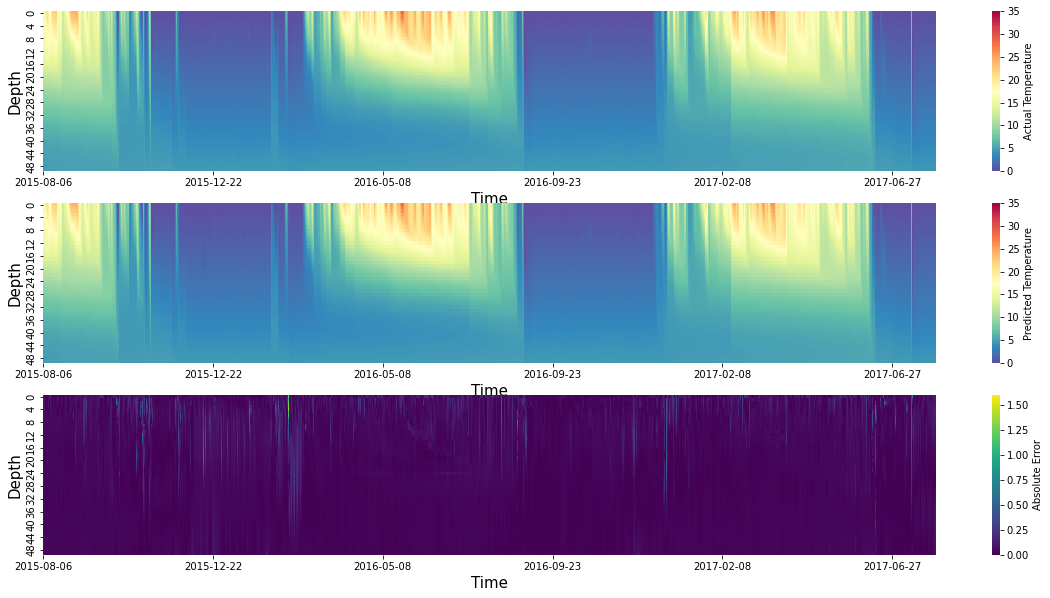

In [26]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

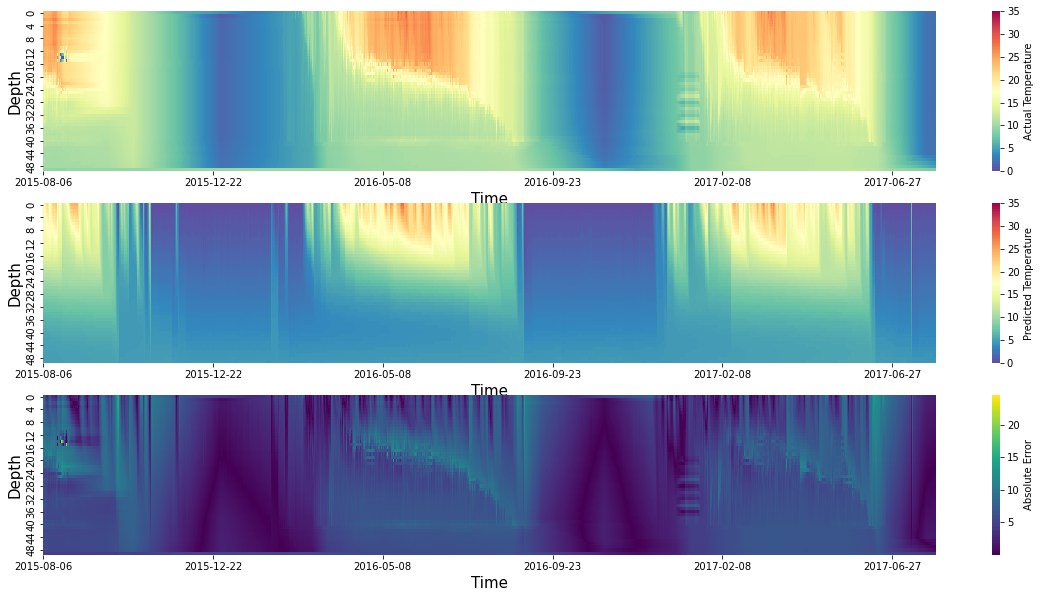

In [27]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [28]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.04349529181305193, Train L2 Error: 0.0057276601087314395
Test RMSE: 0.058766599809652265, Train L2 Error: 0.007387817348391442


## Mixing Model

## Convection Model

In [29]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.016564466585520927, Train L2 Error: 0.0021814161585095035
Test RMSE: 0.018082867571663358, Train L2 Error: 0.0022734152265340805


## Ice Model

In [30]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.014016497076078948, Train L2 Error: 0.0018445259825475508
Test RMSE: 0.01633510608431941, Train L2 Error: 0.0020521246787989266


# Finetuning

In [31]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [32]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [33]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [34]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out3 = torch.tensor(train_mean[m3_output_column_ix[0]]).float().to(device)
std_out3 = torch.tensor(train_std[m3_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m4_pred = ice_model(m4_input)
        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)

        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out3)/std_out3
        
        loss_m3 = criterion(m3_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m3
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:09<2:30:33,  9.04s/it]

Epoch : 0, Train_loss: 0.8233822223840161, Loss m0: 1.2437386282922334e-05, Loss m1: 0.011170538487326735,  Loss m3: 0.8233822223840161, Loss m4: 1.4927743421425768e-05


  5%|▌         | 51/1000 [08:06<2:12:46,  8.39s/it]

Epoch : 50, Train_loss: 0.14238552666766185, Loss m0: 1.2437386282922334e-05, Loss m1: 0.7628235563786915,  Loss m3: 0.14238552666766185, Loss m4: 1.4927743421425768e-05


 10%|█         | 101/1000 [15:51<3:03:09, 12.22s/it]

Epoch : 100, Train_loss: 0.12709113160066818, Loss m0: 1.2437386282922334e-05, Loss m1: 0.7945656489323546,  Loss m3: 0.12709113160066818, Loss m4: 1.4927743421425768e-05


 15%|█▌        | 151/1000 [24:41<1:57:34,  8.31s/it]

Epoch : 150, Train_loss: 0.11672179982407285, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8082141721625877,  Loss m3: 0.11672179982407285, Loss m4: 1.4927743421425768e-05


 20%|██        | 201/1000 [31:39<1:54:47,  8.62s/it]

Epoch : 200, Train_loss: 0.10860798160955121, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8196650365631938,  Loss m3: 0.10860798160955121, Loss m4: 1.4927743421425768e-05


 25%|██▌       | 251/1000 [38:35<1:41:20,  8.12s/it]

Epoch : 250, Train_loss: 0.1021775887622197, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8290338163997114,  Loss m3: 0.1021775887622197, Loss m4: 1.4927743421425768e-05


 30%|███       | 301/1000 [45:23<1:31:51,  7.88s/it]

Epoch : 300, Train_loss: 0.09693368933950308, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8373416750615106,  Loss m3: 0.09693368933950308, Loss m4: 1.4927743421425768e-05


 35%|███▌      | 351/1000 [52:16<1:26:02,  7.96s/it]

Epoch : 350, Train_loss: 0.0925062675532473, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8443204316656437,  Loss m3: 0.0925062675532473, Loss m4: 1.4927743421425768e-05


 40%|████      | 401/1000 [58:44<1:16:43,  7.69s/it]

Epoch : 400, Train_loss: 0.08868781786252058, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8500021213372869,  Loss m3: 0.08868781786252058, Loss m4: 1.4927743421425768e-05


 45%|████▌     | 451/1000 [1:05:25<1:24:53,  9.28s/it]

Epoch : 450, Train_loss: 0.08530601649427094, Loss m0: 1.2437386282922334e-05, Loss m1: 0.854649935990657,  Loss m3: 0.08530601649427094, Loss m4: 1.4927743421425768e-05


 50%|█████     | 501/1000 [1:12:37<1:09:12,  8.32s/it]

Epoch : 500, Train_loss: 0.08225408006082932, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8585734431512645,  Loss m3: 0.08225408006082932, Loss m4: 1.4927743421425768e-05


 55%|█████▌    | 551/1000 [1:19:27<1:00:50,  8.13s/it]

Epoch : 550, Train_loss: 0.07949333212203234, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8621580122624192,  Loss m3: 0.07949333212203234, Loss m4: 1.4927743421425768e-05


 60%|██████    | 601/1000 [1:26:11<56:51,  8.55s/it]  

Epoch : 600, Train_loss: 0.077020401031951, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8656861584879109,  Loss m3: 0.077020401031951, Loss m4: 1.4927743421425768e-05


 65%|██████▌   | 651/1000 [1:33:15<46:52,  8.06s/it]  

Epoch : 650, Train_loss: 0.07483580662306465, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8692702546996668,  Loss m3: 0.07483580662306465, Loss m4: 1.4927743421425768e-05


 70%|███████   | 701/1000 [1:39:49<39:08,  7.85s/it]

Epoch : 700, Train_loss: 0.07291483656513294, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8728683960951006,  Loss m3: 0.07291483656513294, Loss m4: 1.4927743421425768e-05


 75%|███████▌  | 751/1000 [1:46:21<32:38,  7.87s/it]

Epoch : 750, Train_loss: 0.07122346691560609, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8765009522511233,  Loss m3: 0.07122346691560609, Loss m4: 1.4927743421425768e-05


 80%|████████  | 801/1000 [1:52:50<25:20,  7.64s/it]

Epoch : 800, Train_loss: 0.06976170823139143, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8800912063736445,  Loss m3: 0.06976170823139143, Loss m4: 1.4927743421425768e-05


 85%|████████▌ | 851/1000 [1:59:19<19:18,  7.77s/it]

Epoch : 850, Train_loss: 0.06854143201126227, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8834227834260433,  Loss m3: 0.06854143201126227, Loss m4: 1.4927743421425768e-05


 90%|█████████ | 901/1000 [2:05:49<12:52,  7.81s/it]

Epoch : 900, Train_loss: 0.06754512978344093, Loss m0: 1.2437386282922334e-05, Loss m1: 0.886391129702358,  Loss m3: 0.06754512978344093, Loss m4: 1.4927743421425768e-05


 95%|█████████▌| 951/1000 [2:12:18<06:25,  7.88s/it]

Epoch : 950, Train_loss: 0.06670188689657519, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8889653673690611,  Loss m3: 0.06670188689657519, Loss m4: 1.4927743421425768e-05


100%|██████████| 1000/1000 [2:18:38<00:00,  8.32s/it]


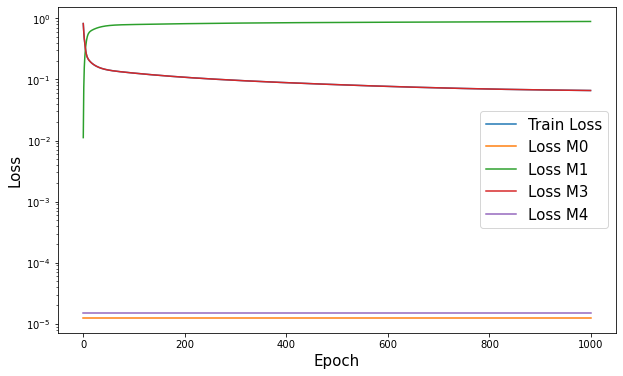

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [36]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.015955927
RMSE of after m1 0.019903485
RMSE of after m3 3.1295438
RMSE of after m4 2.6865609
RMSE of after m0 0.014518581
RMSE of after m1 0.055837248
RMSE of after m3 4.2308745
RMSE of after m4 4.1009946
RMSE of after m0 0.022985889
RMSE of after m1 0.04009601
RMSE of after m3 5.730066
RMSE of after m4 5.496514
RMSE of after m0 0.023267046
RMSE of after m1 0.02467512
RMSE of after m3 5.4459476
RMSE of after m4 5.2155266
RMSE of after m0 0.020757074
RMSE of after m1 0.02009003
RMSE of after m3 5.110183
RMSE of after m4 4.9169707
RMSE of after m0 0.019228224
RMSE of after m1 0.016826741
RMSE of after m3 4.948533
RMSE of after m4 4.7655435
RMSE of after m0 0.018557398
RMSE of after m1 0.015764339
RMSE of after m3 4.9335275
RMSE of after m4 4.7258782
RMSE of after m0 0.018134614
RMSE of after m1 0.015549683
RMSE of after m3 4.903478
RMSE of after m4 4.6934166
RMSE of after m0 0.01839736
RMSE of after m1 0.016086038
RMSE of after m3 4.942503
RMSE of after m4 4.7303414
RM

RMSE of after m1 0.01927361
RMSE of after m3 3.4224565
RMSE of after m4 2.95378
RMSE of after m0 0.02259553
RMSE of after m1 0.01963386
RMSE of after m3 3.4918623
RMSE of after m4 3.0196803
RMSE of after m0 0.022369167
RMSE of after m1 0.020612603
RMSE of after m3 3.474082
RMSE of after m4 3.0074208
RMSE of after m0 0.023179486
RMSE of after m1 0.025340695
RMSE of after m3 3.4704888
RMSE of after m4 2.9706545
RMSE of after m0 0.021602333
RMSE of after m1 0.02387725
RMSE of after m3 3.4825761
RMSE of after m4 2.970978
RMSE of after m0 0.01873591
RMSE of after m1 0.019503085
RMSE of after m3 3.6411846
RMSE of after m4 3.0998297
RMSE of after m0 0.020469714
RMSE of after m1 0.0204879
RMSE of after m3 3.9357815
RMSE of after m4 3.3336914
RMSE of after m0 0.020873852
RMSE of after m1 0.024717608
RMSE of after m3 4.7803426
RMSE of after m4 3.9848874
RMSE of after m0 0.022970745
RMSE of after m1 0.02456015
RMSE of after m3 4.634937
RMSE of after m4 3.89589
RMSE of after m0 0.018848438
RMSE of

RMSE of after m4 3.2567933
RMSE of after m0 0.0073662754
RMSE of after m1 0.011420626
RMSE of after m3 3.0676363
RMSE of after m4 3.2523513
RMSE of after m0 0.007691673
RMSE of after m1 0.010866899
RMSE of after m3 3.1539662
RMSE of after m4 3.3250048
RMSE of after m0 0.009188379
RMSE of after m1 0.01126226
RMSE of after m3 3.2303464
RMSE of after m4 3.3902376
RMSE of after m0 0.009206981
RMSE of after m1 0.010321087
RMSE of after m3 3.2416716
RMSE of after m4 3.4124856
RMSE of after m0 0.009089295
RMSE of after m1 0.010631722
RMSE of after m3 3.277985
RMSE of after m4 3.4560668
RMSE of after m0 0.00799167
RMSE of after m1 0.010626613
RMSE of after m3 3.4314017
RMSE of after m4 3.6502187
RMSE of after m0 0.008825115
RMSE of after m1 0.013106328
RMSE of after m3 3.4256651
RMSE of after m4 3.6670046
RMSE of after m0 0.010953018
RMSE of after m1 0.015220422
RMSE of after m3 3.4031682
RMSE of after m4 3.6173506
RMSE of after m0 0.009173058
RMSE of after m1 0.014213214
RMSE of after m3 3.37

RMSE of after m1 0.022642896
RMSE of after m3 4.0893598
RMSE of after m4 5.0656633
RMSE of after m0 0.00991457
RMSE of after m1 0.020774668
RMSE of after m3 3.959067
RMSE of after m4 4.8076873
RMSE of after m0 0.011591311
RMSE of after m1 0.020857643
RMSE of after m3 4.1898403
RMSE of after m4 5.175339
RMSE of after m0 0.011593412
RMSE of after m1 0.022620937
RMSE of after m3 4.28566
RMSE of after m4 5.399093
RMSE of after m0 0.010982517
RMSE of after m1 0.020978441
RMSE of after m3 4.2000227
RMSE of after m4 5.295007
RMSE of after m0 0.010214393
RMSE of after m1 0.021390636
RMSE of after m3 4.169644
RMSE of after m4 5.278087
RMSE of after m0 0.0099554155
RMSE of after m1 0.020566091
RMSE of after m3 4.079546
RMSE of after m4 5.0819635
RMSE of after m0 0.01041229
RMSE of after m1 0.018725535
RMSE of after m3 4.214273
RMSE of after m4 5.2392974
RMSE of after m0 0.010821615
RMSE of after m1 0.020351026
RMSE of after m3 4.158243
RMSE of after m4 5.16954
RMSE of after m0 0.012248541
RMSE o

RMSE of after m0 0.0070486306
RMSE of after m1 0.0096371155
RMSE of after m3 7.996393
RMSE of after m4 8.100969
RMSE of after m0 0.0059876433
RMSE of after m1 0.008764446
RMSE of after m3 7.9359126
RMSE of after m4 8.086996
RMSE of after m0 0.00649155
RMSE of after m1 0.008171711
RMSE of after m3 7.969769
RMSE of after m4 8.0422945
RMSE of after m0 0.0069554397
RMSE of after m1 0.0079555
RMSE of after m3 7.8659215
RMSE of after m4 7.8965282
RMSE of after m0 0.006981749
RMSE of after m1 0.008129739
RMSE of after m3 7.578232
RMSE of after m4 7.697002
RMSE of after m0 0.007108601
RMSE of after m1 0.009072618
RMSE of after m3 7.3825474
RMSE of after m4 7.57333
RMSE of after m0 0.008439446
RMSE of after m1 0.010110047
RMSE of after m3 7.0659456
RMSE of after m4 7.3652573
RMSE of after m0 0.0074229348
RMSE of after m1 0.007002893
RMSE of after m3 7.8904
RMSE of after m4 7.9232635
RMSE of after m0 0.009119543
RMSE of after m1 0.009891466
RMSE of after m3 9.140098
RMSE of after m4 8.381245
RMS

RMSE of after m3 4.1421676
RMSE of after m4 3.6511717
RMSE of after m0 0.01728295
RMSE of after m1 0.017737217
RMSE of after m3 4.0002513
RMSE of after m4 3.5472054
RMSE of after m0 0.016834516
RMSE of after m1 0.014388266
RMSE of after m3 3.7829742
RMSE of after m4 3.3473568
RMSE of after m0 0.017702194
RMSE of after m1 0.015151337
RMSE of after m3 3.7235045
RMSE of after m4 3.2704136
RMSE of after m0 0.01889585
RMSE of after m1 0.017317543
RMSE of after m3 3.6219313
RMSE of after m4 3.1947982
RMSE of after m0 0.018864669
RMSE of after m1 0.016548766
RMSE of after m3 3.4770753
RMSE of after m4 3.0878983
RMSE of after m0 0.017994946
RMSE of after m1 0.017189289
RMSE of after m3 3.524288
RMSE of after m4 3.0562882
RMSE of after m0 0.017674606
RMSE of after m1 0.016999021
RMSE of after m3 3.348962
RMSE of after m4 2.9571574
RMSE of after m0 0.01747124
RMSE of after m1 0.017695822
RMSE of after m3 3.2541475
RMSE of after m4 2.9169955
RMSE of after m0 0.017171212
RMSE of after m1 0.0152263

RMSE of after m4 0.8996797
RMSE of after m0 0.025094327
RMSE of after m1 0.020449892
RMSE of after m3 1.2037699
RMSE of after m4 1.0845407
RMSE of after m0 0.02589228
RMSE of after m1 0.021323912
RMSE of after m3 1.262375
RMSE of after m4 1.1416677
RMSE of after m0 0.02469893
RMSE of after m1 0.019358888
RMSE of after m3 1.2285975
RMSE of after m4 1.1083791
RMSE of after m0 0.022686914
RMSE of after m1 0.017330043
RMSE of after m3 1.1514695
RMSE of after m4 1.0336716
RMSE of after m0 0.02406953
RMSE of after m1 0.018381488
RMSE of after m3 1.1763055
RMSE of after m4 1.0563654
RMSE of after m0 0.02370774
RMSE of after m1 0.01986879
RMSE of after m3 1.3136601
RMSE of after m4 1.1900082
RMSE of after m0 0.024337156
RMSE of after m1 0.02069449
RMSE of after m3 1.3243622
RMSE of after m4 1.1996814
RMSE of after m0 0.023404686
RMSE of after m1 0.01940408
RMSE of after m3 1.2829766
RMSE of after m4 1.1596555
RMSE of after m0 0.025298007
RMSE of after m1 0.019581852
RMSE of after m3 1.237803
R

RMSE of after m1 0.025379164
RMSE of after m3 3.6399827
RMSE of after m4 2.6201448
RMSE of after m0 0.022634923
RMSE of after m1 0.025090594
RMSE of after m3 3.959028
RMSE of after m4 2.7658925
RMSE of after m0 0.023902705
RMSE of after m1 0.027353782
RMSE of after m3 3.9204664
RMSE of after m4 2.6832225
RMSE of after m0 0.022990946
RMSE of after m1 0.024866821
RMSE of after m3 3.930093
RMSE of after m4 2.682021
RMSE of after m0 0.019450672
RMSE of after m1 0.0248246
RMSE of after m3 4.1771984
RMSE of after m4 2.8415978
RMSE of after m0 0.018526468
RMSE of after m1 0.025548445
RMSE of after m3 4.2211027
RMSE of after m4 2.8828456
RMSE of after m0 0.018734073
RMSE of after m1 0.023045748
RMSE of after m3 4.4347067
RMSE of after m4 3.0252378
RMSE of after m0 0.021459829
RMSE of after m1 0.02863707
RMSE of after m3 4.565339
RMSE of after m4 3.0564682
RMSE of after m0 0.021037592
RMSE of after m1 0.030484062
RMSE of after m3 4.633258
RMSE of after m4 3.1033149
RMSE of after m0 0.020822093


RMSE of after m4 5.1974945
RMSE of after m0 0.007895335
RMSE of after m1 0.015502597
RMSE of after m3 4.196962
RMSE of after m4 5.1859403
RMSE of after m0 0.008718764
RMSE of after m1 0.013475934
RMSE of after m3 4.268272
RMSE of after m4 5.157783
RMSE of after m0 0.009209134
RMSE of after m1 0.015218137
RMSE of after m3 4.2397766
RMSE of after m4 5.1505647
RMSE of after m0 0.010445049
RMSE of after m1 0.016766142
RMSE of after m3 4.2137413
RMSE of after m4 5.139815
RMSE of after m0 0.011175525
RMSE of after m1 0.0183395
RMSE of after m3 4.145815
RMSE of after m4 5.067046
RMSE of after m0 0.010715699
RMSE of after m1 0.019210465
RMSE of after m3 4.0598187
RMSE of after m4 4.964213
RMSE of after m0 0.011205905
RMSE of after m1 0.020935385
RMSE of after m3 3.9988937
RMSE of after m4 4.897896
RMSE of after m0 0.008712079
RMSE of after m1 0.017331915
RMSE of after m3 3.992098
RMSE of after m4 4.7708993
RMSE of after m0 0.010282469
RMSE of after m1 0.019652212
RMSE of after m3 3.9885209
RMS

RMSE of after m1 0.020598628
RMSE of after m3 4.1320395
RMSE of after m4 4.9188957
RMSE of after m0 0.008178362
RMSE of after m1 0.017750358
RMSE of after m3 4.102383
RMSE of after m4 4.751387
RMSE of after m0 0.009436904
RMSE of after m1 0.015698677
RMSE of after m3 4.255777
RMSE of after m4 4.981476
RMSE of after m0 0.009828801
RMSE of after m1 0.013874234
RMSE of after m3 4.8921
RMSE of after m4 5.858958
RMSE of after m0 0.010338609
RMSE of after m1 0.01499232
RMSE of after m3 5.1486816
RMSE of after m4 6.140074
RMSE of after m0 0.008694731
RMSE of after m1 0.01591312
RMSE of after m3 5.36357
RMSE of after m4 6.363119
RMSE of after m0 0.008116029
RMSE of after m1 0.016168248
RMSE of after m3 5.3232493
RMSE of after m4 6.339765
RMSE of after m0 0.007660518
RMSE of after m1 0.011862673
RMSE of after m3 5.4470367
RMSE of after m4 6.316076
RMSE of after m0 0.008870939
RMSE of after m1 0.012855373
RMSE of after m3 5.634256
RMSE of after m4 6.501324
RMSE of after m0 0.009694372
RMSE of af

RMSE of after m4 6.53863
RMSE of after m0 0.016766569
RMSE of after m1 0.02475893
RMSE of after m3 8.322109
RMSE of after m4 6.379557
RMSE of after m0 0.016260361
RMSE of after m1 0.02219725
RMSE of after m3 8.1224
RMSE of after m4 6.2766542
RMSE of after m0 0.024250977
RMSE of after m1 0.020908687
RMSE of after m3 7.0491085
RMSE of after m4 5.727673
RMSE of after m0 0.013746715
RMSE of after m1 0.02010353
RMSE of after m3 7.601103
RMSE of after m4 6.2578645
RMSE of after m0 0.01569949
RMSE of after m1 0.03732325
RMSE of after m3 8.374952
RMSE of after m4 6.928058
RMSE of after m0 0.0176643
RMSE of after m1 0.017524026
RMSE of after m3 6.9051285
RMSE of after m4 5.689873
RMSE of after m0 0.017011503
RMSE of after m1 0.018092116
RMSE of after m3 6.4925528
RMSE of after m4 5.392736
RMSE of after m0 0.015494188
RMSE of after m1 0.01601196
RMSE of after m3 6.547226
RMSE of after m4 5.442076
RMSE of after m0 0.015178145
RMSE of after m1 0.016401082
RMSE of after m3 6.406533
RMSE of after m4

RMSE of after m0 0.031097278
RMSE of after m1 0.02081889
RMSE of after m3 0.8791872
RMSE of after m4 0.78560734
RMSE of after m0 0.035340752
RMSE of after m1 0.022908576
RMSE of after m3 0.90278065
RMSE of after m4 0.80187
RMSE of after m0 0.036320847
RMSE of after m1 0.022960072
RMSE of after m3 0.93002623
RMSE of after m4 0.8256749
RMSE of after m0 0.028554529
RMSE of after m1 0.021193454
RMSE of after m3 0.90904444
RMSE of after m4 0.8053385
RMSE of after m0 0.030217865
RMSE of after m1 0.022035778
RMSE of after m3 0.96885103
RMSE of after m4 0.8619624
RMSE of after m0 0.030677032
RMSE of after m1 0.021906596
RMSE of after m3 0.97979
RMSE of after m4 0.8659134
RMSE of after m0 0.03589263
RMSE of after m1 0.023725223
RMSE of after m3 1.0133892
RMSE of after m4 0.89802563
RMSE of after m0 0.034756962
RMSE of after m1 0.024237609
RMSE of after m3 1.0682764
RMSE of after m4 0.94511575
RMSE of after m0 0.032978587
RMSE of after m1 0.02489611
RMSE of after m3 1.1037211
RMSE of after m4 0.

RMSE of after m3 2.716097
RMSE of after m4 2.071499
RMSE of after m0 0.02323521
RMSE of after m1 0.02120319
RMSE of after m3 2.945098
RMSE of after m4 2.2084773
RMSE of after m0 0.02437774
RMSE of after m1 0.022093901
RMSE of after m3 2.971221
RMSE of after m4 2.204526
RMSE of after m0 0.025029343
RMSE of after m1 0.025048964
RMSE of after m3 2.8938985
RMSE of after m4 2.167786
RMSE of after m0 0.023932263
RMSE of after m1 0.024808506
RMSE of after m3 2.7499144
RMSE of after m4 2.07369
RMSE of after m0 0.022353021
RMSE of after m1 0.02533728
RMSE of after m3 2.8816245
RMSE of after m4 2.1707761
RMSE of after m0 0.022505313
RMSE of after m1 0.027416093
RMSE of after m3 2.781765
RMSE of after m4 2.1120605
RMSE of after m0 0.021338051
RMSE of after m1 0.026988484
RMSE of after m3 3.0153282
RMSE of after m4 2.263458
RMSE of after m0 0.022209777
RMSE of after m1 0.026983999
RMSE of after m3 3.069834
RMSE of after m4 2.2759662
RMSE of after m0 0.020137418
RMSE of after m1 0.024806777
RMSE of

RMSE of after m4 4.110655
RMSE of after m0 0.007891347
RMSE of after m1 0.011334787
RMSE of after m3 3.7501175
RMSE of after m4 4.189789
RMSE of after m0 0.008878305
RMSE of after m1 0.011965142
RMSE of after m3 3.8030436
RMSE of after m4 4.276942
RMSE of after m0 0.00927531
RMSE of after m1 0.013464523
RMSE of after m3 3.8099895
RMSE of after m4 4.3161025
RMSE of after m0 0.008635366
RMSE of after m1 0.014516048
RMSE of after m3 3.829772
RMSE of after m4 4.37369
RMSE of after m0 0.008362012
RMSE of after m1 0.015161813
RMSE of after m3 3.845091
RMSE of after m4 4.4244957
RMSE of after m0 0.006937523
RMSE of after m1 0.012856175
RMSE of after m3 3.9417622
RMSE of after m4 4.5158963
RMSE of after m0 0.009252721
RMSE of after m1 0.009663219
RMSE of after m3 4.25538
RMSE of after m4 4.8650203
RMSE of after m0 0.008725664
RMSE of after m1 0.011979505
RMSE of after m3 4.3857427
RMSE of after m4 5.036554
RMSE of after m0 0.0088470625
RMSE of after m1 0.012756656
RMSE of after m3 4.6883163
RM

RMSE of after m4 6.994762
RMSE of after m0 0.011391121
RMSE of after m1 0.019634794
RMSE of after m3 5.424621
RMSE of after m4 6.8626294
RMSE of after m0 0.009549014
RMSE of after m1 0.018027378
RMSE of after m3 5.3440847
RMSE of after m4 6.690848
RMSE of after m0 0.008508215
RMSE of after m1 0.013301546
RMSE of after m3 5.7310276
RMSE of after m4 7.109562
RMSE of after m0 0.009516381
RMSE of after m1 0.014189102
RMSE of after m3 5.8019667
RMSE of after m4 7.184866
RMSE of after m0 0.0114465
RMSE of after m1 0.016830444
RMSE of after m3 5.738478
RMSE of after m4 7.1455445
RMSE of after m0 0.010546385
RMSE of after m1 0.016304737
RMSE of after m3 5.7120714
RMSE of after m4 7.142301
RMSE of after m0 0.010961536
RMSE of after m1 0.018422509
RMSE of after m3 5.7414007
RMSE of after m4 7.204169
RMSE of after m0 0.011009387
RMSE of after m1 0.018728023
RMSE of after m3 5.590183
RMSE of after m4 6.9640827
RMSE of after m0 0.009102158
RMSE of after m1 0.016524713
RMSE of after m3 5.381116
RMSE

RMSE of after m3 6.429488
RMSE of after m4 6.4163356
RMSE of after m0 0.007571426
RMSE of after m1 0.007505649
RMSE of after m3 6.413169
RMSE of after m4 6.41364
RMSE of after m0 0.007932889
RMSE of after m1 0.0077351234
RMSE of after m3 6.364736
RMSE of after m4 6.3990736
RMSE of after m0 0.0073936526
RMSE of after m1 0.0069317454
RMSE of after m3 6.712076
RMSE of after m4 6.6935678
RMSE of after m0 0.006852148
RMSE of after m1 0.0082614925
RMSE of after m3 6.7816935
RMSE of after m4 6.721555
RMSE of after m0 0.0067820316
RMSE of after m1 0.007921081
RMSE of after m3 6.767564
RMSE of after m4 6.6518645
RMSE of after m0 0.007763241
RMSE of after m1 0.00652832
RMSE of after m3 6.748675
RMSE of after m4 6.5956388
RMSE of after m0 0.009116339
RMSE of after m1 0.0066336854
RMSE of after m3 6.9314184
RMSE of after m4 6.7169785
RMSE of after m0 0.008619548
RMSE of after m1 0.007228945
RMSE of after m3 6.9882793
RMSE of after m4 6.7331967
RMSE of after m0 0.0064707543
RMSE of after m1 0.00669

RMSE of after m1 0.024004413
RMSE of after m3 4.614026
RMSE of after m4 3.6872363
RMSE of after m0 0.019949839
RMSE of after m1 0.019646326
RMSE of after m3 4.6409464
RMSE of after m4 3.7093513
RMSE of after m0 0.019011714
RMSE of after m1 0.018960424
RMSE of after m3 4.5577517
RMSE of after m4 3.6702461
RMSE of after m0 0.018556582
RMSE of after m1 0.018429924
RMSE of after m3 4.44673
RMSE of after m4 3.608108
RMSE of after m0 0.017927688
RMSE of after m1 0.018093718
RMSE of after m3 4.2674623
RMSE of after m4 3.4799466
RMSE of after m0 0.01950841
RMSE of after m1 0.018495085
RMSE of after m3 4.0639815
RMSE of after m4 3.3236222
RMSE of after m0 0.01932007
RMSE of after m1 0.019872963
RMSE of after m3 3.9805017
RMSE of after m4 3.262426
RMSE of after m0 0.019236928
RMSE of after m1 0.018787881
RMSE of after m3 3.871917
RMSE of after m4 3.1881154
RMSE of after m0 0.018282807
RMSE of after m1 0.020812873
RMSE of after m3 3.7182364
RMSE of after m4 3.097592
RMSE of after m0 0.018917786
R

RMSE of after m1 0.024581397
RMSE of after m3 0.9870649
RMSE of after m4 0.8604727
RMSE of after m0 0.028013302
RMSE of after m1 0.023741353
RMSE of after m3 1.0020869
RMSE of after m4 0.8772636
RMSE of after m0 0.025554735
RMSE of after m1 0.024088576
RMSE of after m3 1.0012366
RMSE of after m4 0.8780643
RMSE of after m0 0.025063438
RMSE of after m1 0.022184974
RMSE of after m3 0.989414
RMSE of after m4 0.86863565
RMSE of after m0 0.025357423
RMSE of after m1 0.024881048
RMSE of after m3 0.929938
RMSE of after m4 0.8091235
RMSE of after m0 0.024594612
RMSE of after m1 0.025002986
RMSE of after m3 0.8861248
RMSE of after m4 0.7720115
RMSE of after m0 0.023616234
RMSE of after m1 0.022692043
RMSE of after m3 0.9235803
RMSE of after m4 0.80631685
RMSE of after m0 0.023523264
RMSE of after m1 0.025703665
RMSE of after m3 0.8690584
RMSE of after m4 0.7563747
RMSE of after m0 0.022505287
RMSE of after m1 0.024051907
RMSE of after m3 1.016807
RMSE of after m4 0.894513
RMSE of after m0 0.0210

RMSE of after m4 3.6497269
RMSE of after m0 0.009302242
RMSE of after m1 0.008208814
RMSE of after m3 3.6685543
RMSE of after m4 3.7332006
RMSE of after m0 0.007818917
RMSE of after m1 0.009731994
RMSE of after m3 3.433092
RMSE of after m4 3.5534177
RMSE of after m0 0.008027062
RMSE of after m1 0.0111665325
RMSE of after m3 3.2567399
RMSE of after m4 3.3806882
RMSE of after m0 0.010240334
RMSE of after m1 0.015256815
RMSE of after m3 3.3240812
RMSE of after m4 3.46762
RMSE of after m0 0.009217435
RMSE of after m1 0.016822824
RMSE of after m3 3.4376
RMSE of after m4 3.4547024
RMSE of after m0 0.008638612
RMSE of after m1 0.007900408
RMSE of after m3 3.1331906
RMSE of after m4 3.204696
RMSE of after m0 0.011302728
RMSE of after m1 0.008448623
RMSE of after m3 3.4426007
RMSE of after m4 3.5921772
RMSE of after m0 0.008718659
RMSE of after m1 0.007527527
RMSE of after m3 3.8462794
RMSE of after m4 4.0110655
RMSE of after m0 0.0087025715
RMSE of after m1 0.008018469
RMSE of after m3 3.93406

RMSE of after m1 0.016871164
RMSE of after m3 4.608058
RMSE of after m4 5.362494
RMSE of after m0 0.0101267295
RMSE of after m1 0.018643107
RMSE of after m3 4.6274853
RMSE of after m4 5.405217
RMSE of after m0 0.011682113
RMSE of after m1 0.020407915
RMSE of after m3 4.6764913
RMSE of after m4 5.493429
RMSE of after m0 0.010046459
RMSE of after m1 0.01429854
RMSE of after m3 5.0012712
RMSE of after m4 5.988203
RMSE of after m0 0.009188552
RMSE of after m1 0.016417041
RMSE of after m3 5.16264
RMSE of after m4 6.2804055
RMSE of after m0 0.007889124
RMSE of after m1 0.015605476
RMSE of after m3 5.718645
RMSE of after m4 7.043179
RMSE of after m0 0.009366494
RMSE of after m1 0.0139764175
RMSE of after m3 6.1362987
RMSE of after m4 7.4024
RMSE of after m0 0.013827279
RMSE of after m1 0.019658111
RMSE of after m3 6.126643
RMSE of after m4 7.3886447
RMSE of after m0 0.011551645
RMSE of after m1 0.017289983
RMSE of after m3 5.4270353
RMSE of after m4 6.7768855
RMSE of after m0 0.009378665
RMSE

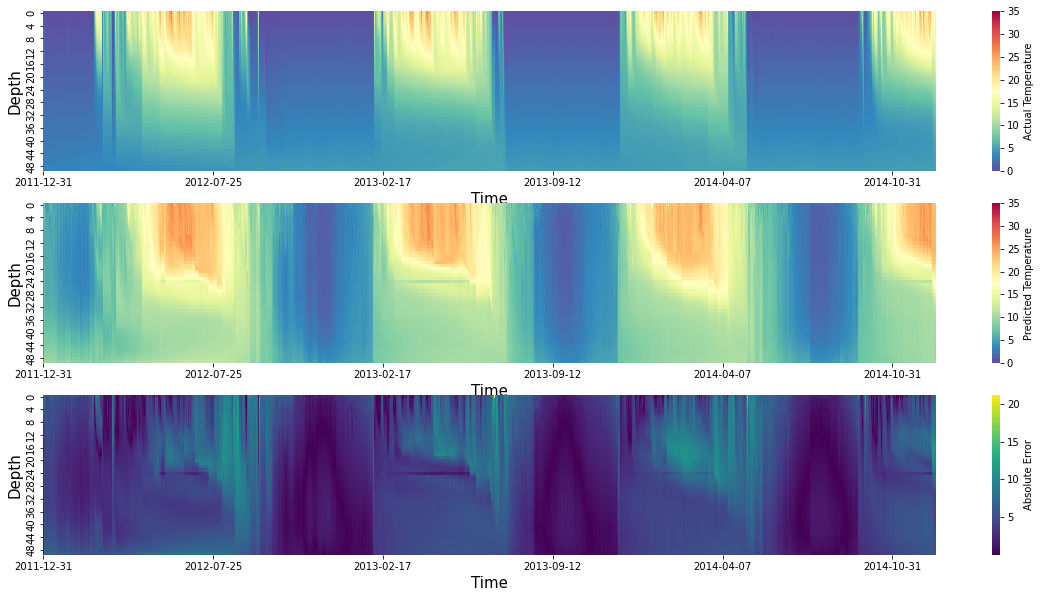

In [37]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

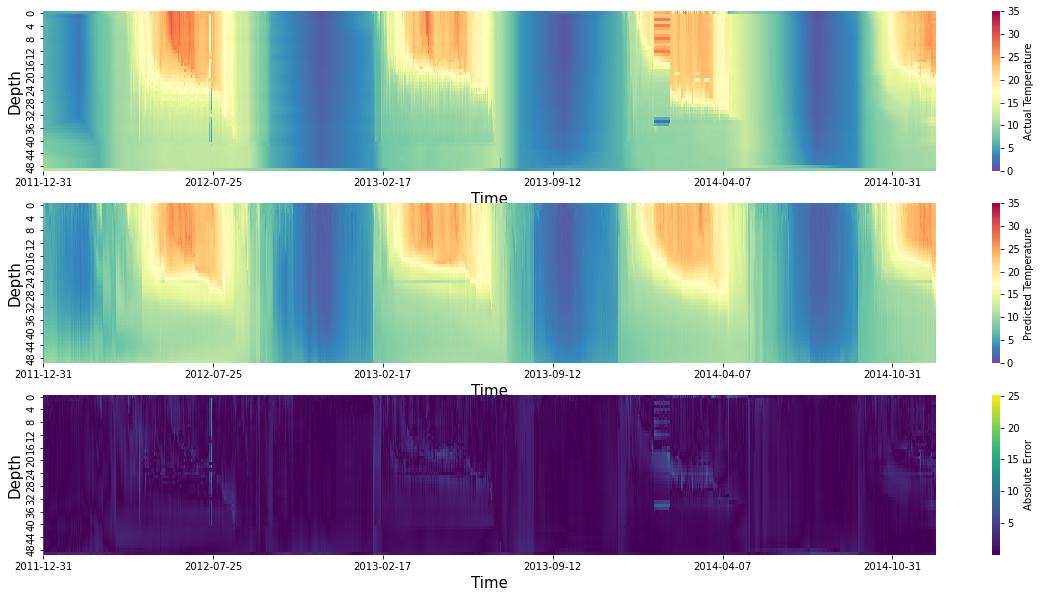

In [38]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [39]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0090550585
RMSE of after m1 0.016522184
RMSE of after m3 5.406334
RMSE of after m4 6.8134613
RMSE of after m0 0.010058648
RMSE of after m1 0.016627615
RMSE of after m3 5.488206
RMSE of after m4 6.850174
RMSE of after m0 0.011175206
RMSE of after m1 0.018848468
RMSE of after m3 5.2136173
RMSE of after m4 6.512738
RMSE of after m0 0.011941654
RMSE of after m1 0.019957943
RMSE of after m3 5.12892
RMSE of after m4 6.425
RMSE of after m0 0.011727795
RMSE of after m1 0.02048253
RMSE of after m3 5.0693464
RMSE of after m4 6.3799133
RMSE of after m0 0.010224279
RMSE of after m1 0.019635735
RMSE of after m3 5.0603685
RMSE of after m4 6.405465
RMSE of after m0 0.008626026
RMSE of after m1 0.01620574
RMSE of after m3 5.0772433
RMSE of after m4 6.36527
RMSE of after m0 0.009490272
RMSE of after m1 0.015358796
RMSE of after m3 5.0894885
RMSE of after m4 6.3202214
RMSE of after m0 0.010674276
RMSE of after m1 0.017634274
RMSE of after m3 5.1510944
RMSE of after m4 6.4283724
RMSE o

RMSE of after m0 0.010768002
RMSE of after m1 0.016099393
RMSE of after m3 5.917095
RMSE of after m4 6.630864
RMSE of after m0 0.007032674
RMSE of after m1 0.012394202
RMSE of after m3 5.740094
RMSE of after m4 6.485983
RMSE of after m0 0.00701507
RMSE of after m1 0.010015175
RMSE of after m3 5.9522147
RMSE of after m4 6.6387777
RMSE of after m0 0.00987505
RMSE of after m1 0.012686832
RMSE of after m3 6.1978717
RMSE of after m4 6.7693996
RMSE of after m0 0.008555338
RMSE of after m1 0.013778052
RMSE of after m3 5.5050354
RMSE of after m4 6.1688247
RMSE of after m0 0.008458383
RMSE of after m1 0.012656327
RMSE of after m3 5.8984795
RMSE of after m4 6.5444922
RMSE of after m0 0.0073385816
RMSE of after m1 0.00959897
RMSE of after m3 6.251844
RMSE of after m4 6.79577
RMSE of after m0 0.0064122505
RMSE of after m1 0.009641298
RMSE of after m3 6.499629
RMSE of after m4 6.9713793
RMSE of after m0 0.0066470597
RMSE of after m1 0.009231579
RMSE of after m3 6.811347
RMSE of after m4 7.131231
RM

RMSE of after m0 0.013133
RMSE of after m1 0.009189127
RMSE of after m3 3.1135604
RMSE of after m4 2.8213694
RMSE of after m0 0.015869312
RMSE of after m1 0.023710232
RMSE of after m3 3.8238406
RMSE of after m4 3.3736134
RMSE of after m0 0.009455182
RMSE of after m1 0.011252523
RMSE of after m3 2.916594
RMSE of after m4 2.7982516
RMSE of after m0 0.011330881
RMSE of after m1 0.012259483
RMSE of after m3 2.7572954
RMSE of after m4 2.6524816
RMSE of after m0 0.012334469
RMSE of after m1 0.013222267
RMSE of after m3 4.0727406
RMSE of after m4 3.5181816
RMSE of after m0 0.012495443
RMSE of after m1 0.012948155
RMSE of after m3 5.1254277
RMSE of after m4 4.259987
RMSE of after m0 0.016353957
RMSE of after m1 0.06451234
RMSE of after m3 5.538727
RMSE of after m4 4.642636
RMSE of after m0 0.018615304
RMSE of after m1 0.022020826
RMSE of after m3 3.1435916
RMSE of after m4 2.6357036
RMSE of after m0 0.020642929
RMSE of after m1 0.02167859
RMSE of after m3 2.9521646
RMSE of after m4 2.532757
RM

RMSE of after m0 0.022517204
RMSE of after m1 0.02370041
RMSE of after m3 1.5556704
RMSE of after m4 1.3666805
RMSE of after m0 0.025466861
RMSE of after m1 0.028481852
RMSE of after m3 1.5379182
RMSE of after m4 1.3388815
RMSE of after m0 0.024095375
RMSE of after m1 0.025848972
RMSE of after m3 1.4851667
RMSE of after m4 1.2975817
RMSE of after m0 0.019385321
RMSE of after m1 0.022751844
RMSE of after m3 1.5879065
RMSE of after m4 1.3852589
RMSE of after m0 0.017370176
RMSE of after m1 0.0236657
RMSE of after m3 1.6380912
RMSE of after m4 1.4317135
RMSE of after m0 0.019359026
RMSE of after m1 0.02599844
RMSE of after m3 1.6304691
RMSE of after m4 1.4317567
RMSE of after m0 0.020198565
RMSE of after m1 0.026951628
RMSE of after m3 1.6912262
RMSE of after m4 1.4751251
RMSE of after m0 0.020453323
RMSE of after m1 0.027571296
RMSE of after m3 1.7376603
RMSE of after m4 1.4768999
RMSE of after m0 0.019821456
RMSE of after m1 0.0302185
RMSE of after m3 1.8054965
RMSE of after m4 1.495654

RMSE of after m1 0.009657013
RMSE of after m3 4.0920267
RMSE of after m4 3.960806
RMSE of after m0 0.008940629
RMSE of after m1 0.009193399
RMSE of after m3 3.8787816
RMSE of after m4 3.7997153
RMSE of after m0 0.008854651
RMSE of after m1 0.009371482
RMSE of after m3 3.6189225
RMSE of after m4 3.5657237
RMSE of after m0 0.008335158
RMSE of after m1 0.010215317
RMSE of after m3 3.6653194
RMSE of after m4 3.5177355
RMSE of after m0 0.006883945
RMSE of after m1 0.009278928
RMSE of after m3 3.5294573
RMSE of after m4 3.3324757
RMSE of after m0 0.0083124675
RMSE of after m1 0.008740981
RMSE of after m3 3.6600027
RMSE of after m4 3.4609249
RMSE of after m0 0.010002536
RMSE of after m1 0.00951149
RMSE of after m3 3.461591
RMSE of after m4 3.381985
RMSE of after m0 0.009463639
RMSE of after m1 0.009538235
RMSE of after m3 3.4733515
RMSE of after m4 3.4434094
RMSE of after m0 0.009088805
RMSE of after m1 0.010608837
RMSE of after m3 3.623605
RMSE of after m4 3.5395267
RMSE of after m0 0.009613

RMSE of after m1 0.015872361
RMSE of after m3 4.73624
RMSE of after m4 5.2482023
RMSE of after m0 0.008742543
RMSE of after m1 0.012098717
RMSE of after m3 4.8689375
RMSE of after m4 5.363392
RMSE of after m0 0.008799872
RMSE of after m1 0.014148939
RMSE of after m3 4.8356
RMSE of after m4 5.370237
RMSE of after m0 0.010054149
RMSE of after m1 0.016864546
RMSE of after m3 4.7573733
RMSE of after m4 5.266012
RMSE of after m0 0.010035212
RMSE of after m1 0.015559104
RMSE of after m3 4.774907
RMSE of after m4 5.3133054
RMSE of after m0 0.009400991
RMSE of after m1 0.016716305
RMSE of after m3 4.77712
RMSE of after m4 5.3645587
RMSE of after m0 0.012549094
RMSE of after m1 0.020786064
RMSE of after m3 4.9118805
RMSE of after m4 5.5097795
RMSE of after m0 0.0071649873
RMSE of after m1 0.013358704
RMSE of after m3 4.8716707
RMSE of after m4 5.3634834
RMSE of after m0 0.00854526
RMSE of after m1 0.01327171
RMSE of after m3 4.9455843
RMSE of after m4 5.488479
RMSE of after m0 0.009075928
RMSE 

RMSE of after m1 0.01754273
RMSE of after m3 5.083131
RMSE of after m4 5.773582
RMSE of after m0 0.009737715
RMSE of after m1 0.018402547
RMSE of after m3 5.1013436
RMSE of after m4 5.8361263
RMSE of after m0 0.009455191
RMSE of after m1 0.015952663
RMSE of after m3 5.253368
RMSE of after m4 5.913071
RMSE of after m0 0.011485204
RMSE of after m1 0.018785577
RMSE of after m3 5.192046
RMSE of after m4 5.825152
RMSE of after m0 0.012601115
RMSE of after m1 0.02161921
RMSE of after m3 5.0032616
RMSE of after m4 5.5433545
RMSE of after m0 0.013370968
RMSE of after m1 0.024036918
RMSE of after m3 4.965903
RMSE of after m4 5.526288
RMSE of after m0 0.012298587
RMSE of after m1 0.02422214
RMSE of after m3 4.8504477
RMSE of after m4 5.3593216
RMSE of after m0 0.00855818
RMSE of after m1 0.021236667
RMSE of after m3 4.860235
RMSE of after m4 5.4127245
RMSE of after m0 0.01036932
RMSE of after m1 0.018321697
RMSE of after m3 4.9022794
RMSE of after m4 5.3319902
RMSE of after m0 0.009405235
RMSE o

RMSE of after m1 0.039791703
RMSE of after m3 9.619665
RMSE of after m4 7.5773177
RMSE of after m0 0.019748256
RMSE of after m1 0.098601356
RMSE of after m3 10.330538
RMSE of after m4 7.6814322
RMSE of after m0 0.020018876
RMSE of after m1 0.08687679
RMSE of after m3 9.557048
RMSE of after m4 7.1682553
RMSE of after m0 0.01926663
RMSE of after m1 0.06457046
RMSE of after m3 9.663017
RMSE of after m4 7.1931133
RMSE of after m0 0.017785776
RMSE of after m1 0.015185935
RMSE of after m3 8.646464
RMSE of after m4 6.544194
RMSE of after m0 0.017693961
RMSE of after m1 0.016871635
RMSE of after m3 8.253793
RMSE of after m4 6.2904077
RMSE of after m0 0.018127643
RMSE of after m1 0.019893166
RMSE of after m3 7.9382772
RMSE of after m4 6.1044526
RMSE of after m0 0.01759288
RMSE of after m1 0.017614119
RMSE of after m3 7.811242
RMSE of after m4 6.0401635
RMSE of after m0 0.017050335
RMSE of after m1 0.018053144
RMSE of after m3 7.6511407
RMSE of after m4 5.9570265
RMSE of after m0 0.017404107
RMS

RMSE of after m1 0.027987147
RMSE of after m3 1.2984906
RMSE of after m4 1.1472858
RMSE of after m0 0.019404164
RMSE of after m1 0.021734811
RMSE of after m3 1.2986144
RMSE of after m4 1.1612866
RMSE of after m0 0.021605097
RMSE of after m1 0.022822501
RMSE of after m3 1.3100457
RMSE of after m4 1.1675388
RMSE of after m0 0.022923574
RMSE of after m1 0.024219522
RMSE of after m3 1.322578
RMSE of after m4 1.1737537
RMSE of after m0 0.02412193
RMSE of after m1 0.023678364
RMSE of after m3 1.2930095
RMSE of after m4 1.1512203
RMSE of after m0 0.02446734
RMSE of after m1 0.02422928
RMSE of after m3 1.2827346
RMSE of after m4 1.143826
RMSE of after m0 0.025000107
RMSE of after m1 0.025318652
RMSE of after m3 1.2245677
RMSE of after m4 1.0973824
RMSE of after m0 0.024134621
RMSE of after m1 0.023906767
RMSE of after m3 1.2253447
RMSE of after m4 1.0987183
RMSE of after m0 0.0219712
RMSE of after m1 0.024718592
RMSE of after m3 1.128359
RMSE of after m4 1.0036886
RMSE of after m0 0.023373129


RMSE of after m1 0.008690273
RMSE of after m3 2.8908668
RMSE of after m4 2.807343
RMSE of after m0 0.010052681
RMSE of after m1 0.009025198
RMSE of after m3 3.053952
RMSE of after m4 2.9565992
RMSE of after m0 0.010848355
RMSE of after m1 0.009849798
RMSE of after m3 2.986094
RMSE of after m4 2.8979445
RMSE of after m0 0.010770778
RMSE of after m1 0.009394594
RMSE of after m3 3.016648
RMSE of after m4 2.9112763
RMSE of after m0 0.009437464
RMSE of after m1 0.008104501
RMSE of after m3 2.7625935
RMSE of after m4 2.710405
RMSE of after m0 0.008577608
RMSE of after m1 0.007010205
RMSE of after m3 2.4929538
RMSE of after m4 2.4825625
RMSE of after m0 0.008481176
RMSE of after m1 0.007136303
RMSE of after m3 2.2972505
RMSE of after m4 2.3148987
RMSE of after m0 0.008067063
RMSE of after m1 0.006384515
RMSE of after m3 2.291267
RMSE of after m4 2.3081648
RMSE of after m0 0.010059019
RMSE of after m1 0.008106481
RMSE of after m3 2.5791552
RMSE of after m4 2.551961
RMSE of after m0 0.012430062

RMSE of after m0 0.008488133
RMSE of after m1 0.010653532
RMSE of after m3 3.9128914
RMSE of after m4 4.378415
RMSE of after m0 0.008612782
RMSE of after m1 0.011969821
RMSE of after m3 3.9503675
RMSE of after m4 4.449925
RMSE of after m0 0.0090677235
RMSE of after m1 0.012567751
RMSE of after m3 3.9727888
RMSE of after m4 4.507281
RMSE of after m0 0.009093659
RMSE of after m1 0.014870563
RMSE of after m3 3.9540696
RMSE of after m4 4.5117373
RMSE of after m0 0.008468483
RMSE of after m1 0.015359696
RMSE of after m3 3.901806
RMSE of after m4 4.470371
RMSE of after m0 0.01006038
RMSE of after m1 0.017118491
RMSE of after m3 3.8312914
RMSE of after m4 4.3821526
RMSE of after m0 0.01152905
RMSE of after m1 0.018009797
RMSE of after m3 3.5331519
RMSE of after m4 4.1476836
RMSE of after m0 0.009811029
RMSE of after m1 0.017782003
RMSE of after m3 3.3507953
RMSE of after m4 3.9005895
RMSE of after m0 0.01070159
RMSE of after m1 0.019391567
RMSE of after m3 3.326489
RMSE of after m4 3.8857667


RMSE of after m0 0.010095272
RMSE of after m1 0.016722163
RMSE of after m3 4.9617352
RMSE of after m4 6.319246
RMSE of after m0 0.009979881
RMSE of after m1 0.017790815
RMSE of after m3 4.9047494
RMSE of after m4 6.287883
RMSE of after m0 0.009472794
RMSE of after m1 0.016487578
RMSE of after m3 4.938409
RMSE of after m4 6.2810097
RMSE of after m0 0.01097203
RMSE of after m1 0.016643627
RMSE of after m3 5.0706673
RMSE of after m4 6.385797
RMSE of after m0 0.010432469
RMSE of after m1 0.016455043
RMSE of after m3 4.8490596
RMSE of after m4 6.120259
RMSE of after m0 0.010739154
RMSE of after m1 0.017175391
RMSE of after m3 4.79072
RMSE of after m4 6.0731015
RMSE of after m0 0.010500145
RMSE of after m1 0.018007541
RMSE of after m3 4.684217
RMSE of after m4 5.9567814
RMSE of after m0 0.010790725
RMSE of after m1 0.019414863
RMSE of after m3 4.580231
RMSE of after m4 5.840684
RMSE of after m0 0.009698799
RMSE of after m1 0.018519314
RMSE of after m3 4.570348
RMSE of after m4 5.774908
RMSE 

RMSE of after m1 0.014215562
RMSE of after m3 4.60215
RMSE of after m4 5.362444
RMSE of after m0 0.00836129
RMSE of after m1 0.013547519
RMSE of after m3 5.010683
RMSE of after m4 5.7773585
RMSE of after m0 0.008432809
RMSE of after m1 0.014397762
RMSE of after m3 4.9739575
RMSE of after m4 5.735878
RMSE of after m0 0.008963771
RMSE of after m1 0.01638095
RMSE of after m3 4.7659016
RMSE of after m4 5.5436807
RMSE of after m0 0.008056452
RMSE of after m1 0.014520785
RMSE of after m3 4.67152
RMSE of after m4 5.3881683
RMSE of after m0 0.008242283
RMSE of after m1 0.013020606
RMSE of after m3 4.672655
RMSE of after m4 5.325265
RMSE of after m0 0.009155877
RMSE of after m1 0.013218779
RMSE of after m3 4.8113313
RMSE of after m4 5.4831595
RMSE of after m0 0.008070931
RMSE of after m1 0.010775316
RMSE of after m3 5.357295
RMSE of after m4 5.971277
RMSE of after m0 0.0071221585
RMSE of after m1 0.010268463
RMSE of after m3 5.8243275
RMSE of after m4 6.395291
RMSE of after m0 0.0071172453
RMSE

RMSE of after m1 0.029970624
RMSE of after m3 10.828565
RMSE of after m4 7.7023067
RMSE of after m0 0.022471914
RMSE of after m1 0.029514635
RMSE of after m3 10.823343
RMSE of after m4 7.5795345
RMSE of after m0 0.020734722
RMSE of after m1 0.030517299
RMSE of after m3 10.861179
RMSE of after m4 7.638316
RMSE of after m0 0.021262977
RMSE of after m1 0.03162854
RMSE of after m3 10.797754
RMSE of after m4 7.52241
RMSE of after m0 0.019629875
RMSE of after m1 0.03418546
RMSE of after m3 11.01593
RMSE of after m4 7.740182
RMSE of after m0 0.019378671
RMSE of after m1 0.033989735
RMSE of after m3 10.840759
RMSE of after m4 7.552025
RMSE of after m0 0.020116882
RMSE of after m1 0.03172576
RMSE of after m3 10.711123
RMSE of after m4 7.368775
RMSE of after m0 0.0189101
RMSE of after m1 0.03214854
RMSE of after m3 10.626933
RMSE of after m4 7.3582563
RMSE of after m0 0.019553876
RMSE of after m1 0.034769822
RMSE of after m3 10.636595
RMSE of after m4 7.438334
RMSE of after m0 0.020400545
RMSE o

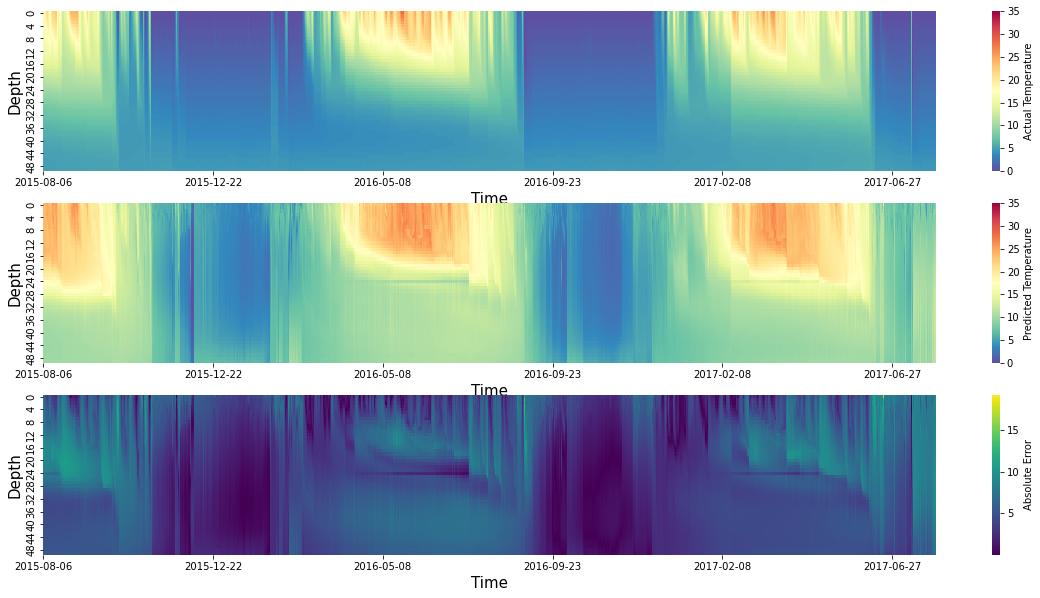

In [40]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

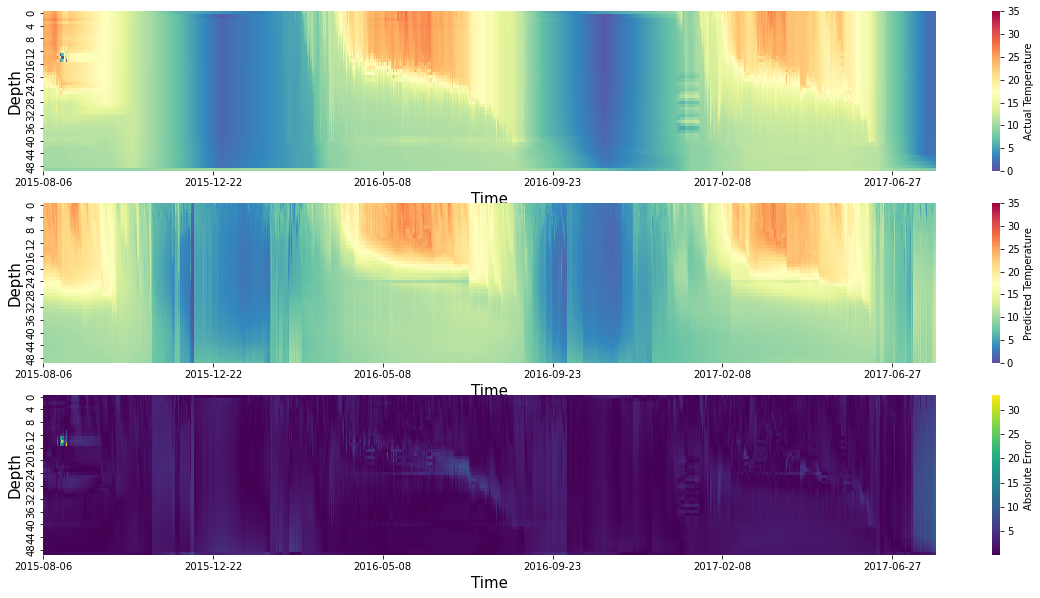

In [41]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [42]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 4.654384295599305, Train L2 Error: 0.612910734688083
Test RMSE: 4.954363714189486, Train L2 Error: 0.6228356637356169


## Mixing Model

## Convection Model

In [43]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.016564466585520927, Train L2 Error: 0.0021814161585095035
Test RMSE: 0.018082867571663358, Train L2 Error: 0.0022734152265340805


## Ice Model

In [44]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.014016497076078948, Train L2 Error: 0.0018445259825475508
Test RMSE: 0.01633510608431941, Train L2 Error: 0.0020521246787989266


# Compute Model Similarity after Finetuning

In [45]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [46]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [47]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9006429314613342
L2 Norm: 8.022515296936035


In [48]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [49]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [50]:
# Freeze all models again and compute finetuned diffusivity values

In [51]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [52]:
PATH = f"./saved_models/diffusion_model_finetuned.pth"
torch.save(heat_diff_model.state_dict(), PATH)

In [53]:
def plot_output_freeLimits(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r')
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r')
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

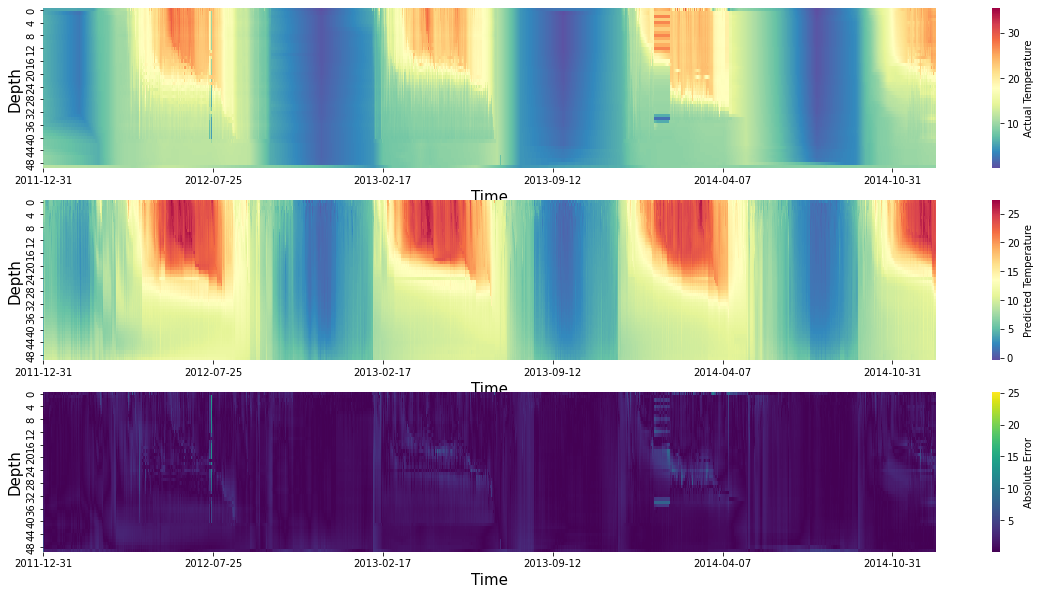

In [54]:
plot_output_freeLimits(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

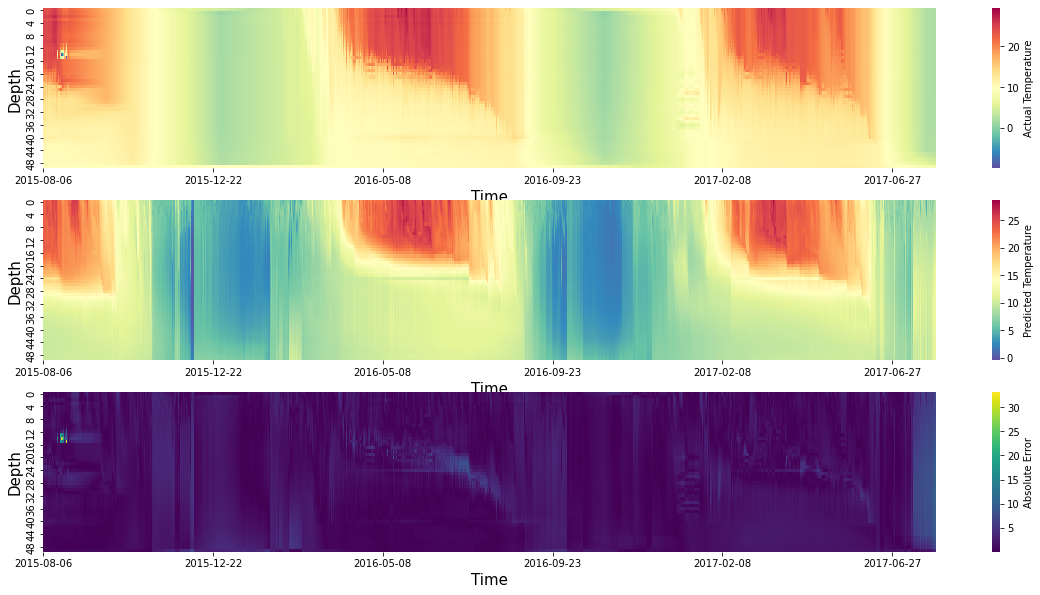

In [55]:
plot_output_freeLimits(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))